In [3]:
import pandas as pd
df = pd.read_csv('/Users/emilianopenaloza/Git/TwitterControl/DyGLib/processed_data/CanParl/ml_CanParl.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/emilianopenaloza/Git/TwitterControl/DyGLib/processed_data/CanParl/ml_CanParl.csv'

In [ ]:
df.ts.unique()[5]

157766400.0

## Generate Synthetic


In [4]:
import networkx as nx
import numpy as np
from statistics import mean 


In [97]:
class BLock_model():
    def __init__(self,n_nodes, n_communities, cov_dictionary , means_dictionary , num_feats) -> None:

        self.arr = np.zeros((n_nodes,num_feats))
        self.n_nodes = n_nodes
        self.nodes_per_community = int(np.floor(n_nodes/ n_communities))
        cur_nodes = 0
        for c in range(n_communities):
            x= np.random.multivariate_normal(means_dictionary[c], cov_dictionary[c], self.nodes_per_community )

            self.arr[cur_nodes:cur_nodes + self.nodes_per_community,:] = x
            cur_nodes += self.nodes_per_community

        self.labels = {i: (lambda x: 0 if x> self.nodes_per_community  else 1)(i) for i in range(n_nodes)}
        self.colors = {i: (lambda x: 'red' if x> self.nodes_per_community  else 'blue')(i) for i in range(self.n_nodes)}
        self.G =nx.Graph()
        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')

    
    def get_distances(self):
        distances = np.zeros((self.arr.shape[0],self.arr.shape[0]))
        for i in range(self.arr.shape[0]): 
            for j in range(self.arr.shape[0]):
                u = self.arr[i,: ]
                v = self.arr[j,:]
                distance = np.linalg.norm(u - v)
                distances[i,j] = distance
        return (distances - np.min(distances))/(np.max(distances) - np.min(distances))
            
            


    def generate_Graph(self,thresh = .1):
        G= nx.Graph()
        distances = self.get_distances()
        def add_edge(i,j): 
            self.G.add_edge(i,j) 
            self.G.add_edge(j,i)
        for i in range(self.arr.shape[0]): 
            for j in range(self.arr.shape[0]):
                if i ==j:
                    continue
                distance = distances[i,j]
                r = np.random.uniform(0,1)
                if distance < thresh: # if the covariates are close it influences the probability of forming an edge
                    if self.labels[i] != self.labels[j]: # not in same community
                        if r > 1:
                            add_edge(i,j)
                    else: # in the same community
                        if r > 0: 
                            add_edge(i,j)
                else:  # if covariates are further apart this decreases the probability of not forming an edge

                    if self.labels[i] != self.labels[j]: # not in same community
                        if  r> 1:
                            add_edge(i,j)
                    else: # in the same community
                        if r > 0: 
                            add_edge(i,j)
        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')
        
    def set_node_features(self):
        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')




        

    def get_edges_and_attributes(self,ts):
        edge_list = nx.to_pandas_edgelist(self.G)
        attr = pd.DataFrame.from_dict(dict(self.G.nodes(data=True)), orient='index')

        for j in range(attr.iloc[:,0].shape[0]):
            # print(f"==>> {attr.iloc[:,j]=} \n {attr=}")
            attr[f'x{j}'] = pd.Series([x[0] for x in attr.iloc[:,0]])

        attr = attr.drop(columns = ['features'])
        edge_list['ts'] = pd.Series([ts for k in range(len(edge_list))])
        
        return edge_list,attr[['x1','x2']].to_numpy()
    def draw(self):
        nx.draw(self.G, pos = nx.spring_layout(self.G), with_labels=True, node_color = [x for x in self.colors.values()])
        plt.show()

    def hist(self):
        # compute the degree distribution
        degree_sequence = sorted([d for n, d in self.G.degree()], reverse=True)
        degree_counts = nx.degree_histogram(self.G)

        # plot the histogram
        plt.bar(range(len(degree_counts)), degree_counts)
        plt.xlabel('Degree')
        plt.ylabel('Count')
        plt.title('Node Degree Histogram')
        plt.show()
                


# mean = [-5, -10]
# cov = [[1, .5], [.5, 2]]


# mean2 = [5, 10]
# cov2 = [[1, 3], [3, 7]]
 
mean = [1]
cov = [[0]]
mean2 = [0]
cov2 = [[0]]
 
means = [mean, mean2]
covs = [cov,cov2]

means_dictionary = {i:x for i,x in enumerate(means)}
cov_dictionary = {i:x for i,x in enumerate(covs)}

block = BLock_model(10,2 ,cov_dictionary,means_dictionary, 1)

block.generate_Graph()
# block.get_edges_and_attributes(0)

In [58]:
block.get_distances()[0]

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

In [ ]:
block.G.nodes[0]

{}

In [35]:
import random

def modify_edges(G, p1= 1, p2 = 0,p3 = .8 ,threshold=.1):
    mean = [2, 5]
    cov = [[1, 0], [1, 0]]
    mean2 = [0, 4]
    cov2 = [[1, 0], [0, 1]]
    means = [mean, mean2]
    covs = [cov,cov2]
    means_dictionary = {i:x for i,x in enumerate(means)}
    cov_dictionary = {i:x for i,x in enumerate(covs)}
    new_block = BLock_model(100,2 ,cov_dictionary,means_dictionary, 2)

    new_distnaces = new_block.get_distances()

    for u in G.nodes():
        for v in G.nodes():
            if u == v:
                continue
            # print(u)
            # Check if u and v are in the same community
            if G.nodes[u]['label'] == G.nodes[v]['label']:
                # Move forward edges with probability p1
                if random.random() < p1:
                    new_block.G.add_edge(u, v)
                
            else:
                # Move forward edges with probability p2
                if random.random() < p2:
                    new_block.G.add_edge(u, v)
                
            # Check if u and v do not have an edge and their current feature is below a certain value
            if not G.has_edge(u, v) and new_distnaces[u,v] < threshold :
                if random.random() < p3:
                    new_block.G.add_edge(u, v)

            # # Check if u and v have an edge and their embeddings have changed above a certain threshold, delete the edge
            # if G.has_edge(u, v) and abs(G.nodes[u]['embedding'] - G.nodes[v]['embedding']) > threshold:
            #     G.remove_edge(u, v)
    # print(new_block.G.nodes)
    return new_block
new_block = modify_edges(block.G)

/tmp/ipykernel_4429/1531792098.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  x= np.random.multivariate_normal(means_dictionary[c], cov_dictionary[c], self.nodes_per_community )


In [99]:
import pandas as pd
mean = [1]
cov = [[0]]
mean2 = [0]
cov2 = [[0]]
# mean2 = [0, 4]
# cov2 = [[1, 0], [0, 1]]

means = [mean, mean2]
covs = [cov,cov2]

means_dictionary = {i:x for i,x in enumerate(means)}
cov_dictionary = {i:x for i,x in enumerate(covs)}
print(means_dictionary)

edges_all = pd.DataFrame()
attr_all = []
num_nodes = 100
base_block = BLock_model(num_nodes,2 ,cov_dictionary,means_dictionary, 1)
base_block.generate_Graph()
prev_edges,previous = base_block.get_edges_and_attributes(0)
edge_lists = []
for i in range(10):
    # block.generate_Graph()
    # new_block =  modify_edges(base_block.G,1,1,0)
    # new_block.set_node_features()
    # print(new_block.G.nodes)


    edges,attr = base_block.get_edges_and_attributes(i)
    assert np.array_equal(previous,attr), f'not equal, {i} , {attr=} {previous= }'
    assert edges[['source','target']].equals(prev_edges[['source','target']]), f'{edges= } {prev_edges=}'
    previous = attr
    prev_edges = edges
    print(attr.shape)
    edge_lists.append(edges)
    if i == 0:
        attr_all = attr
    else:
        attr_all = np.vstack([attr_all,attr])
edges_all = pd.concat(edge_lists,axis = 0)
    # base_block = new_block
print(attr_all.shape)
attr_all = attr_all.reshape((10,num_nodes,2))

{0: [1], 1: [0]}
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(1000, 2)


In [100]:
base = '/home/emiliano/projects/def-cbravo/emiliano/DyGLib/processed_data/Synthetic/'
edges_all= edges_all.rename(columns = {'source': 'u','target':'i'})
edges_all['idx'] = pd.Series([ x for x in range(len(edges_all))])
edges_all['label'] = pd.Series([ 0 for x in range(len(edges_all))])

edges_all.to_csv(f'{base}/ml_Synthetic.csv',index=False)
np.save(f'{base}/ml_Synthetic_node.npy',attr_all[0])
edge_attr = np.ones(len(edges_all)).reshape(-1,1)
np.save(f'{base}/ml_Synthetic.npy',edge_attr)

In [89]:
edges_all

,u,i,ts,idx,label
0,0,1,0,0,0
1,0,2,0,1,0
2,0,3,0,2,0
3,0,4,0,3,0
4,0,5,0,4,0
...,...,...,...,...,...
63475,475,487,9,63475,0
63476,475,496,9,63476,0
63477,478,487,9,63477,0
63478,478,496,9,63478,0


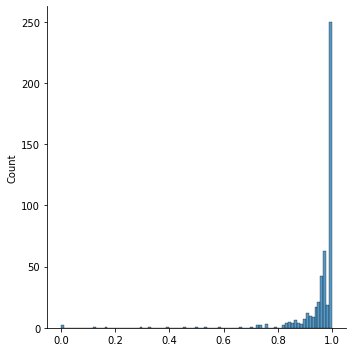

In [96]:
from statistics import mean
import matplotlib.pyplot as plt 
import seaborn as sns
l = []
for u in edges_all.u.unique():
    cur_df = edges_all[edges_all.u == u]
    if u >250:
        prop = cur_df.i.apply(lambda x: 1 if u>250 and x>250 else 0)
    else:
        prop = cur_df.i.apply(lambda x: 1 if u<250 and x<250 else 0)
    l.append(prop.sum()/len(prop))
sns.displot(l)

In [33]:
import numpy as np

# assume these are the source and destination nodes
source_nodes = np.array([1, 2, 3, 4, 5])
dest_nodes = np.array([2, 4, 1, 3, 5])

# assume this is the index of the source node that you want to remove from the destination nodes array
source_index = 2

# find the neighbors of the source node before a certain timestamp
node_id = source_nodes[source_index]
interact_time = 5
i = np.searchsorted(self.nodes_neighbor_times[node_id], interact_time + 1)
neighbors = self.nodes_neighbor_ids[node_id][:i]

# remove the source node from the neighbors array
index_to_remove = np.where(neighbors == node_id)[0]
if len(index_to_remove) > 0:
    neighbors = np.delete(neighbors, index_to_remove[0])

# remove the source node from the destination nodes array
dest_nodes = np.delete(dest_nodes, source_index)

print(neighbors)
print(dest_nodes)


NameError: name 'self' is not defined

In [9]:
d = pd.read_csv('/Users/emilianopenaloza/Git/TwitterControl/DyGLib/processed_data/CanParl/ml_CanParl.csv')
s = set(d.u) | set(d.i)
len(s)

734

In [31]:
import pandas as pd 
import warnings 
warnings.filterwarnings('ignore')

def make_data(df):

    src_node_ids = df.u.values.astype(np.long)
    dst_node_ids = df.i.values.astype(np.long)
    node_interact_times = df.ts.values.astype(np.float64)
    labels = df.label.values
    
    edge_ids = np.array(list(range(len(df.idx.values)))).astype(np.long)
    labels = df.label.values

    formatted_data = Data(src_node_ids=src_node_ids, dst_node_ids=dst_node_ids,
                      node_interact_times=node_interact_times,
                    edge_ids=edge_ids, labels=labels)
    
    return formatted_data
    


def get_dataset_subset(graph_df,percentage):

    sampled = graph_df.groupby('ts', group_keys=False).apply(lambda x: x.sample(frac=percentage))

    graph_df =  graph_df[~graph_df.isin(sampled)].dropna()
   
    return sampled,graph_df


def make_data_dictionaries(graph_dfs , d, edge_raw_features,node_raw_features ,time_varying_features):
    prev_edges = 0

    NODE_FEAT_DIM = EDGE_FEAT_DIM = 172
    for ts,graph_df in enumerate(graph_dfs.items()):
        
        graph_df = graph_df[1]

        new_df = pd.DataFrame(edge_raw_features[prev_edges:prev_edges + len(graph_df)])

        new_df.reset_index(drop=True, inplace=True)
        graph_df.reset_index(drop=True, inplace=True)

        graph_df = pd.concat([graph_df, new_df], axis=1)
        print(graph_df.ts.unique())
    
        if not time_varying_features:
            if node_raw_features.shape[1 ] < NODE_FEAT_DIM:
                node_zero_padding = np.zeros((node_raw_features.shape[0], 172 - node_raw_features.shape[1]))
                node_features[ts] = np.concatenate([node_raw_features, node_zero_padding], axis=1)
            
        else:
            if node_raw_features.shape[2 ] < NODE_FEAT_DIM:
                node_zero_padding = np.zeros((node_raw_features[ts].shape[0], 172 - node_raw_features.shape[1]))
                node_raw_features = np.concatenate([node_raw_features[ts], node_zero_padding], axis=1)

        if edge_raw_features.shape[1] < EDGE_FEAT_DIM:
                edge_zero_padding = np.zeros((edge_raw_features.shape[0], 172 - edge_raw_features.shape[1]))
                edge_raw_features = np.concatenate([edge_raw_features, edge_zero_padding], axis=1)

        assert NODE_FEAT_DIM == node_raw_features.shape[1] and EDGE_FEAT_DIM == edge_raw_features.shape[1], "Unaligned feature dimensions after feature padding!"
   
        d[ts]= {'edges': make_data(graph_df), 'node_features' : node_raw_features , 'edge_features':edge_raw_features}
        prev_edges += len(graph_df)


    return d



def get_link_prediction_data_snapshots(dataset_name: str, val_ratio: float, test_ratio: float):
    """
    generate data for link prediction task (inductive & transductive settings)
    :param dataset_name: str, dataset name
    :param val_ratio: float, validation data ratio
    :param test_ratio: float, test data ratio
    :return: node_raw_features, edge_raw_features, (np.ndarray),
            full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, (Data object)
    """
    # Load data and train val test split
    graph_df = pd.read_csv('./processed_data/{}/ml_{}.csv'.format(dataset_name, dataset_name))
    
    edge_raw_features = np.load('./processed_data/{}/ml_{}.npy'.format(dataset_name, dataset_name))
    node_raw_features = np.load('./processed_data/{}/ml_{}_node.npy'.format(dataset_name, dataset_name))
    cur_edges = 0
    print(f"==>> {graph_df.ts.unique()=}")
    full_data_unstacked = make_data(graph_df)
    if len(node_raw_features.shape) > 2: 
        time_varying_features = True
    else: 
        time_varying_features = False
    val_graph_df , train_graph_df = get_dataset_subset(graph_df, val_ratio)
    print(f"==>> {val_graph_df.ts.unique()=}")

    print(train_graph_df.ts.unique())

    test_graph_df , train_graph_df = get_dataset_subset(train_graph_df, (len(graph_df) * test_ratio ) /len(train_graph_df))
    train_data_unstacked = make_data(train_graph_df)


    train_graph_dfs = dict(tuple(train_graph_df.groupby('ts')))
    val_graph_dfs = dict(tuple(val_graph_df.groupby('ts')))
    test_graph_dfs = dict(tuple(test_graph_df.groupby('ts')))
    



   

        
    train_data = make_data_dictionaries(train_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)
    val_data = make_data_dictionaries(val_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)
    test_data  =make_data_dictionaries(test_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)

    return full_data_unstacked,train_data_unstacked,train_data,val_data,test_data

In [32]:
import numpy as np
full_data_unstacked,train_data_unstacked,train_datas,val_datas,test_datas= \
    get_link_prediction_data_snapshots(dataset_name='CanParl', val_ratio=.1, test_ratio=.2)


==>> graph_df.ts.unique()=array([0.000000e+00, 3.153600e+07, 6.307200e+07, 9.469440e+07,
       1.262304e+08, 1.577664e+08, 1.893024e+08, 2.209248e+08,
       2.524608e+08, 2.839968e+08, 3.155328e+08, 3.471552e+08,
       3.786912e+08, 4.102272e+08])
ts                
0.0          2281             0.0
             668              0.0
             3591             0.0
             11               0.0
             3135             0.0
                         ...     
410227200.0  73743    410227200.0
             72675    410227200.0
             72380    410227200.0
             71592    410227200.0
             72938    410227200.0
Name: ts, Length: 140, dtype: float64
==>> percentage=0.1
==>> graph_df.ts.unique()=array([0.000000e+00, 3.153600e+07, 6.307200e+07, 9.469440e+07,
       1.262304e+08, 1.577664e+08, 1.893024e+08, 2.209248e+08,
       2.524608e+08, 2.839968e+08, 3.155328e+08, 3.471552e+08,
       3.786912e+08, 4.102272e+08])
==>> sampled.ts.unique()=array([0.000000e+00, 3

Exception: 

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention

from models.modules import TimeEncoder
from utils.utils import NeighborSampler


class DyGFormer(nn.Module):

    def __init__(self, node_raw_features: np.ndarray, edge_raw_features: np.ndarray, neighbor_sampler: NeighborSampler,
                 time_feat_dim: int, channel_embedding_dim: int, patch_size: int = 1, num_layers: int = 2, num_heads: int = 2,
                 dropout: float = 0.1, max_input_sequence_length: int = 512, device: str = 'cpu',node_feature_dim= None,edge_feature_dim= None ):
        """
        DyGFormer model.
        :param node_raw_features: ndarray, shape (num_nodes + 1, node_feat_dim)
        :param edge_raw_features: ndarray, shape (num_edges + 1, edge_feat_dim)
        :param neighbor_sampler: neighbor sampler
        :param time_feat_dim: int, dimension of time features (encodings)
        :param channel_embedding_dim: int, dimension of each channel embedding
        :param patch_size: int, patch size
        :param num_layers: int, number of transformer layers
        :param num_heads: int, number of attention heads
        :param dropout: float, dropout rate
        :param max_input_sequence_length: int, maximal length of the input sequence for each node
        :param device: str, device
        """
        super(DyGFormer, self).__init__()
        self.device = device
        if edge_raw_features and node_raw_features:
            self.node_raw_features = torch.from_numpy(node_raw_features.astype(np.float32)).to(device)
            self.edge_raw_features = torch.from_numpy(edge_raw_features.astype(np.float32)).to(device)
            self.node_feat_dim = self.node_raw_features.shape[1]
            self.edge_feat_dim = self.edge_raw_features.shape[1]
        if node_feature_dim and edge_feature_dim:
            self.node_feat_dim = node_feature_dim 
            self.edge_feat_dim = edge_feature_dim


        self.neighbor_sampler = neighbor_sampler
        self.time_feat_dim = time_feat_dim
        self.channel_embedding_dim = channel_embedding_dim
        self.patch_size = patch_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = dropout
        self.max_input_sequence_length = max_input_sequence_length
        self.device = device

        self.time_encoder = TimeEncoder(time_dim=time_feat_dim)

        self.neighbor_co_occurrence_feat_dim = self.channel_embedding_dim
        self.neighbor_co_occurrence_encoder = NeighborCooccurrenceEncoder(neighbor_co_occurrence_feat_dim=self.neighbor_co_occurrence_feat_dim, device=self.device)

        self.projection_layer = nn.ModuleDict({
            'node': nn.Linear(in_features=self.patch_size * self.node_feat_dim, out_features=self.channel_embedding_dim, bias=True),
            'edge': nn.Linear(in_features=self.patch_size * self.edge_feat_dim, out_features=self.channel_embedding_dim, bias=True),
            'time': nn.Linear(in_features=self.patch_size * self.time_feat_dim, out_features=self.channel_embedding_dim, bias=True),
            'neighbor_co_occurrence': nn.Linear(in_features=self.patch_size * self.neighbor_co_occurrence_feat_dim, out_features=self.channel_embedding_dim, bias=True)
        })

        self.num_channels = 4

        self.transformers = nn.ModuleList([
            TransformerEncoder(attention_dim=self.num_channels * self.channel_embedding_dim, num_heads=self.num_heads, dropout=self.dropout)
            for _ in range(self.num_layers)
        ])

        self.output_layer = nn.Linear(in_features=self.num_channels * self.channel_embedding_dim, out_features=self.node_feat_dim, bias=True)
    def set_edge_node_features(self,node_raw_features,edge_raw_features):
        self.node_raw_features = torch.from_numpy(node_raw_features.astype(np.float32)).to(self.device)
        self.edge_raw_features = torch.from_numpy(edge_raw_features.astype(np.float32)).to(self.device)
      
    

         

    def compute_src_dst_node_temporal_embeddings(self, src_node_ids: np.ndarray, dst_node_ids: np.ndarray, node_interact_times: np.ndarray):
        """
        compute source and destination node temporal embeddings
        :param src_node_ids: ndarray, shape (batch_size, )
        :param dst_node_ids: ndarray, shape (batch_size, )
        :param node_interact_times: ndarray, shape (batch_size, )
        :return:
        """
        # get the first-hop neighbors of source and destination nodes
        # three lists to store source nodes' first-hop neighbor ids, edge ids and interaction timestamp information, with batch_size as the list length
        # print(src_node_ids, node_interact_times)
        src_nodes_neighbor_ids_list, src_nodes_edge_ids_list, src_nodes_neighbor_times_list = \
            self.neighbor_sampler.get_all_first_hop_neighbors(node_ids=src_node_ids, node_interact_times=node_interact_times)

        # three lists to store destination nodes' first-hop neighbor ids, edge ids and interaction timestamp information, with batch_size as the list length
        dst_nodes_neighbor_ids_list, dst_nodes_edge_ids_list, dst_nodes_neighbor_times_list = \
            self.neighbor_sampler.get_all_first_hop_neighbors(node_ids=dst_node_ids, node_interact_times=node_interact_times)

        # pad the sequences of first-hop neighbors for source and destination nodes
        # src_padded_nodes_neighbor_ids, ndarray, shape (batch_size, src_max_seq_length)
        # src_padded_nodes_edge_ids, ndarray, shape (batch_size, src_max_seq_length)
        # src_padded_nodes_neighbor_times, ndarray, shape (batch_size, src_max_seq_length)
        src_padded_nodes_neighbor_ids, src_padded_nodes_edge_ids, src_padded_nodes_neighbor_times = \
            self.pad_sequences(node_ids=src_node_ids, node_interact_times=node_interact_times, nodes_neighbor_ids_list=src_nodes_neighbor_ids_list,
                               nodes_edge_ids_list=src_nodes_edge_ids_list, nodes_neighbor_times_list=src_nodes_neighbor_times_list,
                               patch_size=self.patch_size, max_input_sequence_length=self.max_input_sequence_length)

        # dst_padded_nodes_neighbor_ids, ndarray, shape (batch_size, dst_max_seq_length)
        # dst_padded_nodes_edge_ids, ndarray, shape (batch_size, dst_max_seq_length)
        # dst_padded_nodes_neighbor_times, ndarray, shape (batch_size, dst_max_seq_length)
        dst_padded_nodes_neighbor_ids, dst_padded_nodes_edge_ids, dst_padded_nodes_neighbor_times = \
            self.pad_sequences(node_ids=dst_node_ids, node_interact_times=node_interact_times, nodes_neighbor_ids_list=dst_nodes_neighbor_ids_list,
                               nodes_edge_ids_list=dst_nodes_edge_ids_list, nodes_neighbor_times_list=dst_nodes_neighbor_times_list,
                               patch_size=self.patch_size, max_input_sequence_length=self.max_input_sequence_length)

        # src_padded_nodes_neighbor_co_occurrence_features, Tensor, shape (batch_size, src_max_seq_length, neighbor_co_occurrence_feat_dim)
        # dst_padded_nodes_neighbor_co_occurrence_features, Tensor, shape (batch_size, dst_max_seq_length, neighbor_co_occurrence_feat_dim)
        src_padded_nodes_neighbor_co_occurrence_features, dst_padded_nodes_neighbor_co_occurrence_features = \
            self.neighbor_co_occurrence_encoder(src_padded_nodes_neighbor_ids=src_padded_nodes_neighbor_ids,
                                                dst_padded_nodes_neighbor_ids=dst_padded_nodes_neighbor_ids)

        # get the features of the sequence of source and destination nodes
        # src_padded_nodes_neighbor_node_raw_features, Tensor, shape (batch_size, src_max_seq_length, node_feat_dim)
        # src_padded_nodes_edge_raw_features, Tensor, shape (batch_size, src_max_seq_length, edge_feat_dim)
        # src_padded_nodes_neighbor_time_features, Tensor, shape (batch_size, src_max_seq_length, time_feat_dim)
        src_padded_nodes_neighbor_node_raw_features, src_padded_nodes_edge_raw_features, src_padded_nodes_neighbor_time_features = \
            self.get_features(node_interact_times=node_interact_times, padded_nodes_neighbor_ids=src_padded_nodes_neighbor_ids,
                              padded_nodes_edge_ids=src_padded_nodes_edge_ids, padded_nodes_neighbor_times=src_padded_nodes_neighbor_times, time_encoder=self.time_encoder)

        # dst_padded_nodes_neighbor_node_raw_features, Tensor, shape (batch_size, dst_max_seq_length, node_feat_dim)
        # dst_padded_nodes_edge_raw_features, Tensor, shape (batch_size, dst_max_seq_length, edge_feat_dim)
        # dst_padded_nodes_neighbor_time_features, Tensor, shape (batch_size, dst_max_seq_length, time_feat_dim)
        dst_padded_nodes_neighbor_node_raw_features, dst_padded_nodes_edge_raw_features, dst_padded_nodes_neighbor_time_features = \
            self.get_features(node_interact_times=node_interact_times, padded_nodes_neighbor_ids=dst_padded_nodes_neighbor_ids,
                              padded_nodes_edge_ids=dst_padded_nodes_edge_ids, padded_nodes_neighbor_times=dst_padded_nodes_neighbor_times, time_encoder=self.time_encoder)

        # get the patches for source and destination nodes
        # src_patches_nodes_neighbor_node_raw_features, Tensor, shape (batch_size, src_num_patches, patch_size * node_feat_dim)
        # src_patches_nodes_edge_raw_features, Tensor, shape (batch_size, src_num_patches, patch_size * edge_feat_dim)
        # src_patches_nodes_neighbor_time_features, Tensor, shape (batch_size, src_num_patches, patch_size * time_feat_dim)
        src_patches_nodes_neighbor_node_raw_features, src_patches_nodes_edge_raw_features, \
        src_patches_nodes_neighbor_time_features, src_patches_nodes_neighbor_co_occurrence_features = \
            self.get_patches(padded_nodes_neighbor_node_raw_features=src_padded_nodes_neighbor_node_raw_features,
                             padded_nodes_edge_raw_features=src_padded_nodes_edge_raw_features,
                             padded_nodes_neighbor_time_features=src_padded_nodes_neighbor_time_features,
                             padded_nodes_neighbor_co_occurrence_features=src_padded_nodes_neighbor_co_occurrence_features,
                             patch_size=self.patch_size)

        # dst_patches_nodes_neighbor_node_raw_features, Tensor, shape (batch_size, dst_num_patches, patch_size * node_feat_dim)
        # dst_patches_nodes_edge_raw_features, Tensor, shape (batch_size, dst_num_patches, patch_size * edge_feat_dim)
        # dst_patches_nodes_neighbor_time_features, Tensor, shape (batch_size, dst_num_patches, patch_size * time_feat_dim)
        dst_patches_nodes_neighbor_node_raw_features, dst_patches_nodes_edge_raw_features, \
        dst_patches_nodes_neighbor_time_features, dst_patches_nodes_neighbor_co_occurrence_features = \
            self.get_patches(padded_nodes_neighbor_node_raw_features=dst_padded_nodes_neighbor_node_raw_features,
                             padded_nodes_edge_raw_features=dst_padded_nodes_edge_raw_features,
                             padded_nodes_neighbor_time_features=dst_padded_nodes_neighbor_time_features,
                             padded_nodes_neighbor_co_occurrence_features=dst_padded_nodes_neighbor_co_occurrence_features,
                             patch_size=self.patch_size)

        # align the patch encoding dimension
        # Tensor, shape (batch_size, src_num_patches, channel_embedding_dim)
        src_patches_nodes_neighbor_node_raw_features = self.projection_layer['node'](src_patches_nodes_neighbor_node_raw_features)
        src_patches_nodes_edge_raw_features = self.projection_layer['edge'](src_patches_nodes_edge_raw_features)
        src_patches_nodes_neighbor_time_features = self.projection_layer['time'](src_patches_nodes_neighbor_time_features)
        src_patches_nodes_neighbor_co_occurrence_features = self.projection_layer['neighbor_co_occurrence'](src_patches_nodes_neighbor_co_occurrence_features)

        # Tensor, shape (batch_size, dst_num_patches, channel_embedding_dim)
        dst_patches_nodes_neighbor_node_raw_features = self.projection_layer['node'](dst_patches_nodes_neighbor_node_raw_features)
        dst_patches_nodes_edge_raw_features = self.projection_layer['edge'](dst_patches_nodes_edge_raw_features)
        dst_patches_nodes_neighbor_time_features = self.projection_layer['time'](dst_patches_nodes_neighbor_time_features)
        dst_patches_nodes_neighbor_co_occurrence_features = self.projection_layer['neighbor_co_occurrence'](dst_patches_nodes_neighbor_co_occurrence_features)

        batch_size = len(src_patches_nodes_neighbor_node_raw_features)
        src_num_patches = src_patches_nodes_neighbor_node_raw_features.shape[1]
        dst_num_patches = dst_patches_nodes_neighbor_node_raw_features.shape[1]

        # Tensor, shape (batch_size, src_num_patches + dst_num_patches, channel_embedding_dim)
        patches_nodes_neighbor_node_raw_features = torch.cat([src_patches_nodes_neighbor_node_raw_features, dst_patches_nodes_neighbor_node_raw_features], dim=1)
        patches_nodes_edge_raw_features = torch.cat([src_patches_nodes_edge_raw_features, dst_patches_nodes_edge_raw_features], dim=1)
        patches_nodes_neighbor_time_features = torch.cat([src_patches_nodes_neighbor_time_features, dst_patches_nodes_neighbor_time_features], dim=1)
        patches_nodes_neighbor_co_occurrence_features = torch.cat([src_patches_nodes_neighbor_co_occurrence_features, dst_patches_nodes_neighbor_co_occurrence_features], dim=1)

        patches_data = [patches_nodes_neighbor_node_raw_features, patches_nodes_edge_raw_features,
                        patches_nodes_neighbor_time_features, patches_nodes_neighbor_co_occurrence_features]
        # Tensor, shape (batch_size, src_num_patches + dst_num_patches, num_channels, channel_embedding_dim)
        patches_data = torch.stack(patches_data, dim=2)
        # Tensor, shape (batch_size, src_num_patches + dst_num_patches, num_channels * channel_embedding_dim)
        patches_data = patches_data.reshape(batch_size, src_num_patches + dst_num_patches, self.num_channels * self.channel_embedding_dim)

        # Tensor, shape (batch_size, src_num_patches + dst_num_patches, num_channels * channel_embedding_dim)
        for transformer in self.transformers:
            patches_data = transformer(patches_data)

        # src_patches_data, Tensor, shape (batch_size, src_num_patches, num_channels * channel_embedding_dim)
        src_patches_data = patches_data[:, : src_num_patches, :]
        # dst_patches_data, Tensor, shape (batch_size, dst_num_patches, num_channels * channel_embedding_dim)
        dst_patches_data = patches_data[:, src_num_patches: src_num_patches + dst_num_patches, :]
        # src_patches_data, Tensor, shape (batch_size, num_channels * channel_embedding_dim)
        src_patches_data = torch.mean(src_patches_data, dim=1)
        # dst_patches_data, Tensor, shape (batch_size, num_channels * channel_embedding_dim)
        dst_patches_data = torch.mean(dst_patches_data, dim=1)

        # Tensor, shape (batch_size, node_feat_dim)
        src_node_embeddings = self.output_layer(src_patches_data)
        # Tensor, shape (batch_size, node_feat_dim)
        dst_node_embeddings = self.output_layer(dst_patches_data)

        return src_node_embeddings, dst_node_embeddings

    def pad_sequences(self, node_ids: np.ndarray, node_interact_times: np.ndarray, nodes_neighbor_ids_list: list, nodes_edge_ids_list: list,
                      nodes_neighbor_times_list: list, patch_size: int = 1, max_input_sequence_length: int = 256):
        """
        pad the sequences for nodes in node_ids
        :param node_ids: ndarray, shape (batch_size, )
        :param node_interact_times: ndarray, shape (batch_size, )
        :param nodes_neighbor_ids_list: list of ndarrays, each ndarray contains neighbor ids for nodes in node_ids
        :param nodes_edge_ids_list: list of ndarrays, each ndarray contains edge ids for nodes in node_ids
        :param nodes_neighbor_times_list: list of ndarrays, each ndarray contains neighbor interaction timestamp for nodes in node_ids
        :param patch_size: int, patch size
        :param max_input_sequence_length: int, maximal number of neighbors for each node
        :return:
        """
        assert max_input_sequence_length - 1 > 0, 'Maximal number of neighbors for each node should be greater than 1!'
        max_seq_length = 0
        # first cut the sequence of nodes whose number of neighbors is more than max_input_sequence_length - 1 (we need to include the target node in the sequence)
        for idx in range(len(nodes_neighbor_ids_list)):
            assert len(nodes_neighbor_ids_list[idx]) == len(nodes_edge_ids_list[idx]) == len(nodes_neighbor_times_list[idx])
            if len(nodes_neighbor_ids_list[idx]) > max_input_sequence_length - 1:
                # cut the sequence by taking the most recent max_input_sequence_length interactions
                nodes_neighbor_ids_list[idx] = nodes_neighbor_ids_list[idx][-(max_input_sequence_length - 1):]
                nodes_edge_ids_list[idx] = nodes_edge_ids_list[idx][-(max_input_sequence_length - 1):]
                nodes_neighbor_times_list[idx] = nodes_neighbor_times_list[idx][-(max_input_sequence_length - 1):]
            if len(nodes_neighbor_ids_list[idx]) > max_seq_length:
                max_seq_length = len(nodes_neighbor_ids_list[idx])

        # include the target node itself
        max_seq_length += 1
        if max_seq_length % patch_size != 0:
            max_seq_length += (patch_size - max_seq_length % patch_size)
        assert max_seq_length % patch_size  == 0

        # pad the sequences
        # three ndarrays with shape (batch_size, max_seq_length)
        padded_nodes_neighbor_ids = np.zeros((len(node_ids), max_seq_length)).astype(np.long)
        padded_nodes_edge_ids = np.zeros((len(node_ids), max_seq_length)).astype(np.long)
        padded_nodes_neighbor_times = np.zeros((len(node_ids), max_seq_length)).astype(np.float32)

        for idx in range(len(node_ids)):
            padded_nodes_neighbor_ids[idx, 0] = node_ids[idx]
            padded_nodes_edge_ids[idx, 0] = 0
            padded_nodes_neighbor_times[idx, 0] = node_interact_times[idx]

            if len(nodes_neighbor_ids_list[idx]) > 0:
                padded_nodes_neighbor_ids[idx, 1: len(nodes_neighbor_ids_list[idx]) + 1] = nodes_neighbor_ids_list[idx]
                padded_nodes_edge_ids[idx, 1: len(nodes_edge_ids_list[idx]) + 1] = nodes_edge_ids_list[idx]
                padded_nodes_neighbor_times[idx, 1: len(nodes_neighbor_times_list[idx]) + 1] = nodes_neighbor_times_list[idx]

        # three ndarrays with shape (batch_size, max_seq_length)
        return padded_nodes_neighbor_ids, padded_nodes_edge_ids, padded_nodes_neighbor_times

    def get_features(self, node_interact_times: np.ndarray, padded_nodes_neighbor_ids: np.ndarray, padded_nodes_edge_ids: np.ndarray,
                     padded_nodes_neighbor_times: np.ndarray, time_encoder: TimeEncoder):
        """
        get node, edge and time features
        :param node_interact_times: ndarray, shape (batch_size, )
        :param padded_nodes_neighbor_ids: ndarray, shape (batch_size, max_seq_length)
        :param padded_nodes_edge_ids: ndarray, shape (batch_size, max_seq_length)
        :param padded_nodes_neighbor_times: ndarray, shape (batch_size, max_seq_length)
        :param time_encoder: TimeEncoder, time encoder
        :return:
        """
        # Tensor, shape (batch_size, max_seq_length, node_feat_dim)
        padded_nodes_neighbor_node_raw_features = self.node_raw_features[torch.from_numpy(padded_nodes_neighbor_ids)]
        # Tensor, shape (batch_size, max_seq_length, edge_feat_dim)
        padded_nodes_edge_raw_features = self.edge_raw_features[torch.from_numpy(padded_nodes_edge_ids)]
        # Tensor, shape (batch_size, max_seq_length, time_feat_dim)
        padded_nodes_neighbor_time_features = time_encoder(timestamps=torch.from_numpy(node_interact_times[:, np.newaxis] - padded_nodes_neighbor_times).float().to(self.device))

        # ndarray, set the time features to all zeros for the padded timestamp
        padded_nodes_neighbor_time_features[torch.from_numpy(padded_nodes_neighbor_ids == 0)] = 0.0

        return padded_nodes_neighbor_node_raw_features, padded_nodes_edge_raw_features, padded_nodes_neighbor_time_features

    def get_patches(self, padded_nodes_neighbor_node_raw_features: torch.Tensor, padded_nodes_edge_raw_features: torch.Tensor,
                    padded_nodes_neighbor_time_features: torch.Tensor, padded_nodes_neighbor_co_occurrence_features: torch.Tensor = None, patch_size: int = 1):
        """
        get the sequence of patches for nodes
        :param padded_nodes_neighbor_node_raw_features: Tensor, shape (batch_size, max_seq_length, node_feat_dim)
        :param padded_nodes_edge_raw_features: Tensor, shape (batch_size, max_seq_length, edge_feat_dim)
        :param padded_nodes_neighbor_time_features: Tensor, shape (batch_size, max_seq_length, time_feat_dim)
        :param padded_nodes_neighbor_co_occurrence_features: Tensor, shape (batch_size, max_seq_length, neighbor_co_occurrence_feat_dim)
        :param patch_size: int, patch size
        :return:
        """
        assert padded_nodes_neighbor_node_raw_features.shape[1] % patch_size == 0
        num_patches = padded_nodes_neighbor_node_raw_features.shape[1] // patch_size

        # list of Tensors with shape (num_patches, ), each Tensor with shape (batch_size, patch_size, node_feat_dim)
        patches_nodes_neighbor_node_raw_features, patches_nodes_edge_raw_features, \
        patches_nodes_neighbor_time_features, patches_nodes_neighbor_co_occurrence_features = [], [], [], []

        for patch_id in range(num_patches):
            start_idx = patch_id * patch_size
            end_idx = patch_id * patch_size + patch_size
            patches_nodes_neighbor_node_raw_features.append(padded_nodes_neighbor_node_raw_features[:, start_idx: end_idx, :])
            patches_nodes_edge_raw_features.append(padded_nodes_edge_raw_features[:, start_idx: end_idx, :])
            patches_nodes_neighbor_time_features.append(padded_nodes_neighbor_time_features[:, start_idx: end_idx, :])
            patches_nodes_neighbor_co_occurrence_features.append(padded_nodes_neighbor_co_occurrence_features[:, start_idx: end_idx, :])

        batch_size = len(padded_nodes_neighbor_node_raw_features)
        # Tensor, shape (batch_size, num_patches, patch_size * node_feat_dim)
        patches_nodes_neighbor_node_raw_features = torch.stack(patches_nodes_neighbor_node_raw_features, dim=1).reshape(batch_size, num_patches, patch_size * self.node_feat_dim)
        # Tensor, shape (batch_size, num_patches, patch_size * edge_feat_dim)
        patches_nodes_edge_raw_features = torch.stack(patches_nodes_edge_raw_features, dim=1).reshape(batch_size, num_patches, patch_size * self.edge_feat_dim)
        # Tensor, shape (batch_size, num_patches, patch_size * time_feat_dim)
        patches_nodes_neighbor_time_features = torch.stack(patches_nodes_neighbor_time_features, dim=1).reshape(batch_size, num_patches, patch_size * self.time_feat_dim)

        patches_nodes_neighbor_co_occurrence_features = torch.stack(patches_nodes_neighbor_co_occurrence_features, dim=1).reshape(batch_size, num_patches, patch_size * self.neighbor_co_occurrence_feat_dim)

        return patches_nodes_neighbor_node_raw_features, patches_nodes_edge_raw_features, patches_nodes_neighbor_time_features, patches_nodes_neighbor_co_occurrence_features

    def set_neighbor_sampler(self, neighbor_sampler: NeighborSampler):
        """
        set neighbor sampler to neighbor_sampler and reset the random state (for reproducing the results for uniform and time_interval_aware sampling)
        :param neighbor_sampler: NeighborSampler, neighbor sampler
        :return:
        """
        self.neighbor_sampler = neighbor_sampler
        if self.neighbor_sampler.sample_neighbor_strategy in ['uniform', 'time_interval_aware']:
            assert self.neighbor_sampler.seed is not None
            self.neighbor_sampler.reset_random_state()


class NeighborCooccurrenceEncoder(nn.Module):

    def __init__(self, neighbor_co_occurrence_feat_dim: int, device: str = 'cpu'):
        """
        Neighbor co-occurrence encoder.
        :param neighbor_co_occurrence_feat_dim: int, dimension of neighbor co-occurrence features (encodings)
        :param device: str, device
        """
        super(NeighborCooccurrenceEncoder, self).__init__()
        self.neighbor_co_occurrence_feat_dim = neighbor_co_occurrence_feat_dim
        self.device = device

        self.neighbor_co_occurrence_encode_layer = nn.Sequential(
            nn.Linear(in_features=1, out_features=self.neighbor_co_occurrence_feat_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.neighbor_co_occurrence_feat_dim, out_features=self.neighbor_co_occurrence_feat_dim))

    def count_nodes_appearances(self, src_padded_nodes_neighbor_ids: np.ndarray, dst_padded_nodes_neighbor_ids: np.ndarray):
        """
        count the appearances of nodes in the sequences of source and destination nodes
        :param src_padded_nodes_neighbor_ids: ndarray, shape (batch_size, src_max_seq_length)
        :param dst_padded_nodes_neighbor_ids:: ndarray, shape (batch_size, dst_max_seq_length)
        :return:
        """
        # two lists to store the appearances of source and destination nodes
        src_padded_nodes_appearances, dst_padded_nodes_appearances = [], []
        # src_padded_node_neighbor_ids, ndarray, shape (src_max_seq_length, )
        # dst_padded_node_neighbor_ids, ndarray, shape (dst_max_seq_length, )
        for src_padded_node_neighbor_ids, dst_padded_node_neighbor_ids in zip(src_padded_nodes_neighbor_ids, dst_padded_nodes_neighbor_ids):

            # src_unique_keys, ndarray, shape (num_src_unique_keys, )
            # src_inverse_indices, ndarray, shape (src_max_seq_length, )
            # src_counts, ndarray, shape (num_src_unique_keys, )
            # we can use src_unique_keys[src_inverse_indices] to reconstruct the original input, and use src_counts[src_inverse_indices] to get counts of the original input
            src_unique_keys, src_inverse_indices, src_counts = np.unique(src_padded_node_neighbor_ids, return_inverse=True, return_counts=True)
            # Tensor, shape (src_max_seq_length, )
            src_padded_node_neighbor_counts_in_src = torch.from_numpy(src_counts[src_inverse_indices]).float().to(self.device)
            # dictionary, store the mapping relation from unique neighbor id to its appearances for the source node
            src_mapping_dict = dict(zip(src_unique_keys, src_counts))

            # dst_unique_keys, ndarray, shape (num_dst_unique_keys, )
            # dst_inverse_indices, ndarray, shape (dst_max_seq_length, )
            # dst_counts, ndarray, shape (num_dst_unique_keys, )
            # we can use dst_unique_keys[dst_inverse_indices] to reconstruct the original input, and use dst_counts[dst_inverse_indices] to get counts of the original input
            dst_unique_keys, dst_inverse_indices, dst_counts = np.unique(dst_padded_node_neighbor_ids, return_inverse=True, return_counts=True)
            # Tensor, shape (dst_max_seq_length, )
            dst_padded_node_neighbor_counts_in_dst = torch.from_numpy(dst_counts[dst_inverse_indices]).float().to(self.device)
            # dictionary, store the mapping relation from unique neighbor id to its appearances for the destination node
            dst_mapping_dict = dict(zip(dst_unique_keys, dst_counts))

            # we need to use copy() to avoid the modification of src_padded_node_neighbor_ids
            # Tensor, shape (src_max_seq_length, )
            src_padded_node_neighbor_counts_in_dst = torch.from_numpy(src_padded_node_neighbor_ids.copy()).apply_(lambda neighbor_id: dst_mapping_dict.get(neighbor_id, 0.0)).float().to(self.device)
            # Tensor, shape (src_max_seq_length, 2)
            src_padded_nodes_appearances.append(torch.stack([src_padded_node_neighbor_counts_in_src, src_padded_node_neighbor_counts_in_dst], dim=1))

            # we need to use copy() to avoid the modification of dst_padded_node_neighbor_ids
            # Tensor, shape (dst_max_seq_length, )
            dst_padded_node_neighbor_counts_in_src = torch.from_numpy(dst_padded_node_neighbor_ids.copy()).apply_(lambda neighbor_id: src_mapping_dict.get(neighbor_id, 0.0)).float().to(self.device)
            # Tensor, shape (dst_max_seq_length, 2)
            dst_padded_nodes_appearances.append(torch.stack([dst_padded_node_neighbor_counts_in_src, dst_padded_node_neighbor_counts_in_dst], dim=1))

        # Tensor, shape (batch_size, src_max_seq_length, 2)
        src_padded_nodes_appearances = torch.stack(src_padded_nodes_appearances, dim=0)
        # Tensor, shape (batch_size, dst_max_seq_length, 2)
        dst_padded_nodes_appearances = torch.stack(dst_padded_nodes_appearances, dim=0)

        # set the appearances of the padded node (with zero index) to zeros
        # Tensor, shape (batch_size, src_max_seq_length, 2)
        src_padded_nodes_appearances[torch.from_numpy(src_padded_nodes_neighbor_ids == 0)] = 0.0
        # Tensor, shape (batch_size, dst_max_seq_length, 2)
        dst_padded_nodes_appearances[torch.from_numpy(dst_padded_nodes_neighbor_ids == 0)] = 0.0

        return src_padded_nodes_appearances, dst_padded_nodes_appearances

    def forward(self, src_padded_nodes_neighbor_ids: np.ndarray, dst_padded_nodes_neighbor_ids: np.ndarray):
        """
        compute the neighbor co-occurrence features of nodes in src_padded_nodes_neighbor_ids and dst_padded_nodes_neighbor_ids
        :param src_padded_nodes_neighbor_ids: ndarray, shape (batch_size, src_max_seq_length)
        :param dst_padded_nodes_neighbor_ids:: ndarray, shape (batch_size, dst_max_seq_length)
        :return:
        """
        # src_padded_nodes_appearances, Tensor, shape (batch_size, src_max_seq_length, 2)
        # dst_padded_nodes_appearances, Tensor, shape (batch_size, dst_max_seq_length, 2)
        src_padded_nodes_appearances, dst_padded_nodes_appearances = self.count_nodes_appearances(src_padded_nodes_neighbor_ids=src_padded_nodes_neighbor_ids,
                                                                                                  dst_padded_nodes_neighbor_ids=dst_padded_nodes_neighbor_ids)

        # sum the neighbor co-occurrence features in the sequence of source and destination nodes
        # Tensor, shape (batch_size, src_max_seq_length, neighbor_co_occurrence_feat_dim)
        src_padded_nodes_neighbor_co_occurrence_features = self.neighbor_co_occurrence_encode_layer(src_padded_nodes_appearances.unsqueeze(dim=-1)).sum(dim=2)
        # Tensor, shape (batch_size, dst_max_seq_length, neighbor_co_occurrence_feat_dim)
        dst_padded_nodes_neighbor_co_occurrence_features = self.neighbor_co_occurrence_encode_layer(dst_padded_nodes_appearances.unsqueeze(dim=-1)).sum(dim=2)

        # src_padded_nodes_neighbor_co_occurrence_features, Tensor, shape (batch_size, src_max_seq_length, neighbor_co_occurrence_feat_dim)
        # dst_padded_nodes_neighbor_co_occurrence_features, Tensor, shape (batch_size, dst_max_seq_length, neighbor_co_occurrence_feat_dim)
        return src_padded_nodes_neighbor_co_occurrence_features, dst_padded_nodes_neighbor_co_occurrence_features


class TransformerEncoder(nn.Module):

    def __init__(self, attention_dim: int, num_heads: int, dropout: float = 0.1):
        """
        Transformer encoder.
        :param attention_dim: int, dimension of the attention vector
        :param num_heads: int, number of attention heads
        :param dropout: float, dropout rate
        """
        super(TransformerEncoder, self).__init__()
        # use the MultiheadAttention implemented by PyTorch
        self.multi_head_attention = MultiheadAttention(embed_dim=attention_dim, num_heads=num_heads, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

        self.linear_layers = nn.ModuleList([
            nn.Linear(in_features=attention_dim, out_features=4 * attention_dim),
            nn.Linear(in_features=4 * attention_dim, out_features=attention_dim)
        ])
        self.norm_layers = nn.ModuleList([
            nn.LayerNorm(attention_dim),
            nn.LayerNorm(attention_dim)
        ])

    def forward(self, inputs: torch.Tensor):
        """
        encode the inputs by Transformer encoder
        :param inputs: Tensor, shape (batch_size, num_patches, self.attention_dim)
        :return:
        """
        # note that the MultiheadAttention module accept input data with shape (seq_length, batch_size, input_dim), so we need to transpose the input
        # Tensor, shape (num_patches, batch_size, self.attention_dim)
        transposed_inputs = inputs.transpose(0, 1)
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        transposed_inputs = self.norm_layers[0](transposed_inputs)
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        hidden_states = self.multi_head_attention(query=transposed_inputs, key=transposed_inputs, value=transposed_inputs)[0].transpose(0, 1)
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        outputs = inputs + self.dropout(hidden_states)
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        hidden_states = self.linear_layers[1](self.dropout(F.gelu(self.linear_layers[0](self.norm_layers[1](outputs)))))
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        outputs = outputs + self.dropout(hidden_states)
        return outputs


In [4]:
import logging
import time
import sys
import os
from tqdm import tqdm
import numpy as np
import warnings
import shutil
import json
import torch
import torch.nn as nn

from models.TGAT import TGAT
from models.MemoryModel import MemoryModel, compute_src_dst_node_time_shifts
from models.CAWN import CAWN
from models.TCL import TCL
from models.GraphMixer import GraphMixer
from models.DyGFormer import DyGFormer
from models.modules import MergeLayer
from utils.utils import set_random_seed, convert_to_gpu, get_parameter_sizes, create_optimizer
from utils.utils import get_neighbor_sampler, NegativeEdgeSampler
from evaluate_models_utils import evaluate_model_link_prediction
from utils.metrics import get_link_prediction_metrics
from utils.DataLoader import get_idx_data_loader, get_link_prediction_data
from utils.EarlyStopping import EarlyStopping
from utils.load_configs import get_link_prediction_args
from torch.utils.data import Dataset, DataLoader
import numpy as np
from IPython.display import display
import random
import pandas as pd

class Data:

    def __init__(self, src_node_ids: np.ndarray, dst_node_ids: np.ndarray, node_interact_times: np.ndarray, edge_ids: np.ndarray, labels: np.ndarray):
        """
        Data object to store the nodes interaction information.
        :param src_node_ids: ndarray
        :param dst_node_ids: ndarray
        :param node_interact_times: ndarray
        :param edge_ids: ndarray
        :param labels: ndarray
        """
        self.src_node_ids = src_node_ids
        self.dst_node_ids = dst_node_ids
        self.node_interact_times = node_interact_times
        self.edge_ids = edge_ids
        self.labels = labels
        self.num_interactions = len(src_node_ids)
        self.unique_node_ids = set(src_node_ids) | set(dst_node_ids)
        self.num_unique_nodes = len(self.unique_node_ids)


from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import pandas as pd


class CustomizedDataset(Dataset):
    def __init__(self, indices_list: list):
        """
        Customized dataset.
        :param indices_list: list, list of indices
        """
        super(CustomizedDataset, self).__init__()

        self.indices_list = indices_list

    def __getitem__(self, idx: int):
        """
        get item at the index in self.indices_list
        :param idx: int, the index
        :return:
        """
        return self.indices_list[idx]

    def __len__(self):
        return len(self.indices_list)


def get_idx_data_loader(indices_list: list, batch_size: int, shuffle: bool):
    """
    get data loader that iterates over indices
    :param indices_list: list, list of indices
    :param batch_size: int, batch size
    :param shuffle: boolean, whether to shuffle the data
    :return: data_loader, DataLoader
    """
    dataset = CustomizedDataset(indices_list=indices_list)

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             drop_last=False)
    return data_loader

def get_snpashot_idx_data_loaders(datasets: dict, batch_size: int, shuffle: bool):
    """
    get data loader that iterates over indices
    :param indices_list: list, list of indices
    :param batch_size: int, batch size
    :param shuffle: boolean, whether to shuffle the data
    :return: data_loader, DataLoader
    """
    out = {}
    for ts in datasets.keys():  
        dataset = CustomizedDataset(indices_list=list(range(len(datasets[ts]['edges'].src_node_ids))))

        data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             drop_last=False)
        out[ts] = data_loader
    return out


In [3]:
def make_data(df):

    src_node_ids = df.u.values.astype(np.long)

    dst_node_ids = df.i.values.astype(np.long)
    node_interact_times = df.ts.values.astype(np.float64)
    edge_ids = df.idx.values.astype(np.long)
    labels = df.label.values

    nodes_set = set(src_node_ids) | set(dst_node_ids)
    num_total_unique_node_ids = len(nodes_set)
    src_node_ids = df.u.values.astype(np.long)

    dst_node_ids = df.i.values.astype(np.long)
    node_interact_times = df.ts.values.astype(np.float64)
    edge_ids = np.array(list(range(len(df.idx.values)))).astype(np.long)
    labels = df.label.values

    train_data = Data(src_node_ids=src_node_ids, dst_node_ids=dst_node_ids,
                      node_interact_times=node_interact_times,
                    edge_ids=edge_ids, labels=labels)
    return train_data
    


def get_dataset_subset(graph_df,percentage):
    grouped = graph_df.groupby('ts')

    # Define a function to sample each group proportionally


    def percentage_sample(group, percentage):
        n = int(len(group) * percentage)
        return group.sample(n)


    # Apply the proportional_sample function to each group
    sampled = grouped.apply(percentage_sample, percentage=percentage).reset_index(drop=True)
    graph_df =  graph_df[~graph_df.isin(sampled)].dropna()
    return sampled,graph_df

def make_data_dictionaries(graph_dfs , d, edge_raw_features,node_raw_features ,time_varying_features):
    prev_edges = 0

    NODE_FEAT_DIM = EDGE_FEAT_DIM = 172
    for ts,graph_df in enumerate(graph_dfs.items()):
        graph_df = graph_df[1]


        new_df = pd.DataFrame(edge_raw_features[prev_edges:prev_edges + len(graph_df)])
        new_df.reset_index(drop=True, inplace=True)
   
        graph_df.reset_index(drop=True, inplace=True)

       
        graph_df = pd.concat([graph_df, new_df], axis=1)
 

        orginal_length = len(graph_df)
            


    
        if not time_varying_features:
            if node_raw_features.shape[1 ] < NODE_FEAT_DIM:
                node_zero_padding = np.zeros((node_raw_features.shape[0], 172 - node_raw_features.shape[1]))
                node_features[ts] = np.concatenate([node_raw_features, node_zero_padding], axis=1)
            
            
        else:
            if node_raw_features.shape[2 ] < NODE_FEAT_DIM:
                node_zero_padding = np.zeros((node_raw_features[ts].shape[0], 172 - node_raw_features.shape[1]))
                node_raw_features = np.concatenate([node_raw_features[ts], node_zero_padding], axis=1)

        if edge_raw_features.shape[1] < EDGE_FEAT_DIM:
                edge_zero_padding = np.zeros((edge_raw_features.shape[0], 172 - edge_raw_features.shape[1]))
                edge_raw_features = np.concatenate([edge_raw_features, edge_zero_padding], axis=1)

        assert NODE_FEAT_DIM == node_raw_features.shape[1] and EDGE_FEAT_DIM == edge_raw_features.shape[1], "Unaligned feature dimensions after feature padding!"
   
        d[ts]= {'edges': make_data(graph_df), 'node_features' : node_raw_features , 'edge_features':edge_raw_features}
        prev_edges += len(graph_df)

    return d



def get_link_prediction_data_snapshots(dataset_name: str, val_ratio: float, test_ratio: float):
    """
    generate data for link prediction task (inductive & transductive settings)
    :param dataset_name: str, dataset name
    :param val_ratio: float, validation data ratio
    :param test_ratio: float, test data ratio
    :return: node_raw_features, edge_raw_features, (np.ndarray),
            full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, (Data object)
    """
    # Load data and train val test split
    graph_df = pd.read_csv('./processed_data/{}/ml_{}.csv'.format(dataset_name, dataset_name))
    
    edge_raw_features = np.load('./processed_data/{}/ml_{}.npy'.format(dataset_name, dataset_name))
    node_raw_features = np.load('./processed_data/{}/ml_{}_node.npy'.format(dataset_name, dataset_name))
    cur_edges = 0
    full_data_unstacked = make_data(graph_df)
    if len(node_raw_features.shape) > 2: 
        time_varying_features = True
    else: 
        time_varying_features = False
  
    val_graph_df , train_graph_df = get_dataset_subset(graph_df, val_ratio)

    test_graph_df , train_graph_df = get_dataset_subset(train_graph_df, (len(graph_df) * test_ratio ) /len(train_graph_df))
    train_data_unstacked = make_data(train_graph_df)
    test_data_unstacked = make_data(test_graph_df)
    val_data_unstacked = make_data(val_graph_df)

    train_graph_dfs = dict(tuple(train_graph_df.groupby('ts')))
    val_graph_dfs = dict(tuple(val_graph_df.groupby('ts')))
    test_graph_dfs = dict(tuple(test_graph_df.groupby('ts')))
    



   

        
    train_data = make_data_dictionaries(train_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)
    val_data = make_data_dictionaries(val_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)
    test_data  =make_data_dictionaries(test_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)

    return full_data_unstacked,train_data_unstacked,train_data,val_data,test_data
  

warnings.filterwarnings('ignore')

# get arguments
args = get_link_prediction_args(is_evaluation=False)

# get data for training, validation and testing
full_data_unstacked,train_data_unstacked,train_datas,val_datas,test_datas= \
    get_link_prediction_data_snapshots(dataset_name=args.dataset_name, val_ratio=args.val_ratio, test_ratio=args.test_ratio)


In [4]:
from torch.utils.data import Dataset, DataLoader

train_neighbor_sampler = get_neighbor_sampler(data=train_data_unstacked, sample_neighbor_strategy=args.sample_neighbor_strategy,
                                                time_scaling_factor=args.time_scaling_factor, seed=0)


full_neighbor_sampler = get_neighbor_sampler(data=full_data_unstacked, sample_neighbor_strategy=args.sample_neighbor_strategy,
                                                time_scaling_factor=args.time_scaling_factor, seed=1)





train_neg_edge_sampler = NegativeEdgeSampler(src_node_ids=train_data_unstacked.src_node_ids, dst_node_ids=train_data_unstacked.dst_node_ids)
val_neg_edge_sampler = NegativeEdgeSampler(src_node_ids=full_data_unstacked.src_node_ids, dst_node_ids=full_data_unstacked.dst_node_ids, seed=0)
test_neg_edge_sampler = NegativeEdgeSampler(src_node_ids=full_data_unstacked.src_node_ids, dst_node_ids=full_data_unstacked.dst_node_ids, seed=2)




In [139]:
train_datas[0]['edges'].src_node_ids

array([475, 254,  87, ..., 175, 159, 354])

In [5]:

# get data loaders

train_data_loaders = get_snpashot_idx_data_loaders(train_datas, batch_size=args.batch_size, shuffle=False)
val_data_loaders = get_snpashot_idx_data_loaders(val_datas, batch_size=args.batch_size, shuffle=False)
test_data_loaders = get_snpashot_idx_data_loaders(test_datas,  batch_size=args.batch_size, shuffle=False)



In [14]:

val_metric_all_runs, new_node_val_metric_all_runs, test_metric_all_runs, new_node_test_metric_all_runs = [], [], [], []




args.save_model_name = f'{args.model_name}'

# set up logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
os.makedirs(f"./logs/{args.model_name}/{args.dataset_name}/{args.save_model_name}/", exist_ok=True)
# create file handler that logs debug and higher level messages
fh = logging.FileHandler(f"./logs/{args.model_name}/{args.dataset_name}/{args.save_model_name}/{str(time.time())}.log")
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.WARNING)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to logger
logger.addHandler(fh)
logger.addHandler(ch)

run_start_time = time.time()


logger.info(f'configuration is {args}')


node_feature_dim = train_datas[0]['node_features'].shape[1]
edge_feature_dim = train_datas[0]['edge_features'].shape[1]

dynamic_backbone = DyGFormer(node_raw_features=None, edge_raw_features=None, neighbor_sampler=train_neighbor_sampler,
                                    time_feat_dim=args.time_feat_dim, channel_embedding_dim=args.channel_embedding_dim, patch_size=args.patch_size,
                                    num_layers=args.num_layers, num_heads=args.num_heads, dropout=args.dropout,
                                    max_input_sequence_length=args.max_input_sequence_length, device=args.device,
                                    edge_feature_dim = train_datas[0]['edge_features'].shape[1],
                                    node_feature_dim = train_datas[0]['node_features'].shape[1])

link_predictor = MergeLayer(input_dim1=node_feature_dim, input_dim2=node_feature_dim,
                            hidden_dim=node_feature_dim, output_dim=1)
model = nn.Sequential(dynamic_backbone, link_predictor)
logger.info(f'model -> {model}')
logger.info(f'model name: {args.model_name}, #parameters: {get_parameter_sizes(model) * 4} B, '
            f'{get_parameter_sizes(model) * 4 / 1024} KB, {get_parameter_sizes(model) * 4 / 1024 / 1024} MB.')

optimizer = create_optimizer(model=model, optimizer_name=args.optimizer, learning_rate=args.learning_rate, weight_decay=args.weight_decay)

model = convert_to_gpu(model, device=args.device)

save_model_folder = f"./saved_models/{args.model_name}/{args.dataset_name}/{args.save_model_name}/"
shutil.rmtree(save_model_folder, ignore_errors=True)
os.makedirs(save_model_folder, exist_ok=True)

early_stopping = EarlyStopping(patience=args.patience, save_model_folder=save_model_folder,
                                save_model_name=args.save_model_name, logger=logger, model_name=args.model_name)

loss_func = nn.BCELoss()


INFO:root:configuration is Namespace(batch_size=200, channel_embedding_dim=50, dataset_name='CanParl', device='cpu', dropout=0.1, edge_bank_memory_mode='unlimited_memory', gpu=0, learning_rate=0.0001, load_best_configs=False, max_input_sequence_length=32, model_name='DyGFormer', negative_sample_strategy='random', num_epochs=30, num_heads=2, num_layers=2, num_neighbors=20, num_runs=5, num_walk_heads=8, optimizer='Adam', patch_size=1, patience=20, position_feat_dim=172, sample_neighbor_strategy='recent', save_model_name='DyGFormer', test_interval_epochs=10, test_ratio=0.15, time_feat_dim=100, time_gap=2000, time_scaling_factor=1e-06, time_window_mode='fixed_proportion', val_ratio=0.15, walk_length=1, weight_decay=0.0)
INFO:root:model -> Sequential(
  (0): DyGFormer(
    (time_encoder): TimeEncoder(
      (w): Linear(in_features=1, out_features=100, bias=True)
    )
    (neighbor_co_occurrence_encoder): NeighborCooccurrenceEncoder(
      (neighbor_co_occurrence_encode_layer): Sequential(


In [16]:
snapshots = train_data_loaders.keys()
for epoch in range(args.num_epochs):

    model.train()
    
    model[0].set_neighbor_sampler(train_neighbor_sampler)
    for ts in snapshots :
        train_idx_data_loader = train_data_loaders[ts]
        # store train losses and metrics
        train_data = train_datas[ts]['edges']
        edge_features = train_datas[ts]['edge_features']
        node_features = train_datas[ts]['node_features']
        model[0].set_edge_node_features(node_features,edge_features)
        train_losses, train_metrics = [], []
        train_idx_data_loader_tqdm = tqdm(train_idx_data_loader, ncols=120)
        
        for batch_idx, train_data_indices in enumerate(train_idx_data_loader_tqdm):
            batch_src_node_ids, batch_dst_node_ids, batch_node_interact_times, batch_edge_ids = \
                train_data.src_node_ids[train_data_indices], train_data.dst_node_ids[train_data_indices], \
                train_data.node_interact_times[train_data_indices], train_data.edge_ids[train_data_indices]

            _, batch_neg_dst_node_ids = train_neg_edge_sampler.sample(size=len(batch_src_node_ids))
            batch_neg_src_node_ids = batch_src_node_ids

            
            
            # get temporal embedding of source and destination nodes
            # two Tensors, with shape (batch_size, node_feat_dim)
            batch_src_node_embeddings, batch_dst_node_embeddings = \
                model[0].compute_src_dst_node_temporal_embeddings(src_node_ids=batch_src_node_ids,
                                                                    dst_node_ids=batch_dst_node_ids,
                                                                    node_interact_times=batch_node_interact_times)

            # get temporal embedding of negative source and negative destination nodes
            # two Tensors, with shape (batch_size, node_feat_dim)
            batch_neg_src_node_embeddings, batch_neg_dst_node_embeddings = \
                model[0].compute_src_dst_node_temporal_embeddings(src_node_ids=batch_neg_src_node_ids,
                                                                    dst_node_ids=batch_neg_dst_node_ids,
                                                                    node_interact_times=batch_node_interact_times)
            
            
            positive_probabilities = model[1](input_1=batch_src_node_embeddings, input_2=batch_dst_node_embeddings).squeeze(dim=-1).sigmoid()
            negative_probabilities = model[1](input_1=batch_neg_src_node_embeddings, input_2=batch_neg_dst_node_embeddings).squeeze(dim=-1).sigmoid()

            predicts = torch.cat([positive_probabilities, negative_probabilities], dim=0)
            labels = torch.cat([torch.ones_like(positive_probabilities), torch.zeros_like(negative_probabilities)], dim=0)
            try:
                loss = loss_func(input=predicts, target=labels)
            except Exception:

                print(predicts,labels)
                raise Exception

            train_losses.append(loss.item())

            train_metrics.append(get_link_prediction_metrics(predicts=predicts, labels=labels))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_idx_data_loader_tqdm.set_description(f'Epoch: {epoch + 1}, at timestamp : {ts} train for the {batch_idx + 1}-th batch, train loss: {loss.item()}')


Epoch: 1, at timestamp : 0 train for the 9-th batch, train loss: 0.7082639336585999: 100%|█| 9/9 [00:01<00:00,  5.82it/s
Epoch: 1, at timestamp : 1 train for the 26-th batch, train loss: 0.20162926614284515: 100%|█| 26/26 [00:44<00:00,  1.72
Epoch: 1, at timestamp : 2 train for the 23-th batch, train loss: 0.37661921977996826: 100%|█| 23/23 [00:45<00:00,  1.96
Epoch: 1, at timestamp : 3 train for the 16-th batch, train loss: 0.5609734654426575: 100%|█| 16/16 [00:31<00:00,  1.99s
Epoch: 1, at timestamp : 4 train for the 34-th batch, train loss: 0.6407334804534912:  81%|▊| 34/42 [01:04<00:15,  1.90s

: 

: 

In [65]:


#         val_losses, val_metrics = evaluate_model_link_prediction(model_name=args.model_name,
#                                                                     model=model,
#                                                                     neighbor_sampler=full_neighbor_sampler,
#                                                                     evaluate_idx_data_loader=val_idx_data_loader,
#                                                                     evaluate_neg_edge_sampler=val_neg_edge_sampler,
#                                                                     evaluate_data=val_data,
#                                                                     loss_func=loss_func,
#                                                                     num_neighbors=args.num_neighbors,
#                                                                     time_gap=args.time_gap)
# )

#         new_node_val_losses, new_node_val_metrics = evaluate_model_link_prediction(model_name=args.model_name,
#                                                                                     model=model,
#                                                                                     neighbor_sampler=full_neighbor_sampler,
#                                                                                     evaluate_idx_data_loader=new_node_val_idx_data_loader,
#                                                                                     evaluate_neg_edge_sampler=new_node_val_neg_edge_sampler,
#                                                                                     evaluate_data=new_node_val_data,
#                                                                                     loss_func=loss_func,
#                                                                                     num_neighbors=args.num_neighbors,
#                                                                                     time_gap=args.time_gap)

      
#         logger.info(f'Epoch: {epoch + 1}, learning rate: {optimizer.param_groups[0]["lr"]}, train loss: {np.mean(train_losses):.4f}')
#         for metric_name in train_metrics[0].keys():
#             logger.info(f'train {metric_name}, {np.mean([train_metric[metric_name] for train_metric in train_metrics]):.4f}')
#         logger.info(f'validate loss: {np.mean(val_losses):.4f}')
#         for metric_name in val_metrics[0].keys():
#             logger.info(f'validate {metric_name}, {np.mean([val_metric[metric_name] for val_metric in val_metrics]):.4f}')
#         logger.info(f'new node validate loss: {np.mean(new_node_val_losses):.4f}')
#         for metric_name in new_node_val_metrics[0].keys():
#             logger.info(f'new node validate {metric_name}, {np.mean([new_node_val_metric[metric_name] for new_node_val_metric in new_node_val_metrics]):.4f}')

#         # perform testing once after test_interval_epochs
#         if (epoch + 1) % args.test_interval_epochs == 0:
#             test_losses, test_metrics = evaluate_model_link_prediction(model_name=args.model_name,
#                                                                         model=model,
#                                                                         neighbor_sampler=full_neighbor_sampler,
#                                                                         evaluate_idx_data_loader=test_idx_data_loader,
#                                                                         evaluate_neg_edge_sampler=test_neg_edge_sampler,
#                                                                         evaluate_data=test_data,
#                                                                         loss_func=loss_func,
#                                                                         num_neighbors=args.num_neighbors,
#                                                                         time_gap=args.time_gap)

            

#             new_node_test_losses, new_node_test_metrics = evaluate_model_link_prediction(model_name=args.model_name,
#                                                                                             model=model,
#                                                                                             neighbor_sampler=full_neighbor_sampler,
#                                                                                             evaluate_idx_data_loader=new_node_test_idx_data_loader,
#                                                                                             evaluate_neg_edge_sampler=new_node_test_neg_edge_sampler,
#                                                                                             evaluate_data=new_node_test_data,
#                                                                                             loss_func=loss_func,
#                                                                                             num_neighbors=args.num_neighbors,
#                                                                                             time_gap=args.time_gap)

        #     if args.model_name in ['JODIE', 'DyRep', 'TGN']:
        #         # reload validation memory bank for testing nodes or saving models
        #         # note that since model treats memory as parameters, we need to reload the memory to val_backup_memory_bank for saving models
        #         model[0].memory_bank.reload_memory_bank(val_backup_memory_bank)

        #     logger.info(f'test loss: {np.mean(test_losses):.4f}')
        #     for metric_name in test_metrics[0].keys():
        #         logger.info(f'test {metric_name}, {np.mean([test_metric[metric_name] for test_metric in test_metrics]):.4f}')
        #     logger.info(f'new node test loss: {np.mean(new_node_test_losses):.4f}')
        #     for metric_name in new_node_test_metrics[0].keys():
        #         logger.info(f'new node test {metric_name}, {np.mean([new_node_test_metric[metric_name] for new_node_test_metric in new_node_test_metrics]):.4f}')

        # # select the best model based on all the validate metrics
        # val_metric_indicator = []
        # for metric_name in val_metrics[0].keys():
        #     val_metric_indicator.append((metric_name, np.mean([val_metric[metric_name] for val_metric in val_metrics]), True))
        # early_stop = early_stopping.step(val_metric_indicator, model)

        # if early_stop:
            break

# load the best model
early_stopping.load_checkpoint(model)

# evaluate the best model
logger.info(f'get final performance on dataset {args.dataset_name}...')

# the saved best model of memory-based models cannot perform validation since the stored memory has been updated by validation data
if args.model_name not in ['JODIE', 'DyRep', 'TGN']:
    val_losses, val_metrics = evaluate_model_link_prediction(model_name=args.model_name,
                                                                model=model,
                                                                neighbor_sampler=full_neighbor_sampler,
                                                                evaluate_idx_data_loader=val_idx_data_loader,
                                                                evaluate_neg_edge_sampler=val_neg_edge_sampler,
                                                                evaluate_data=val_data,
                                                                loss_func=loss_func,
                                                                num_neighbors=args.num_neighbors,
                                                                time_gap=args.time_gap)

    new_node_val_losses, new_node_val_metrics = evaluate_model_link_prediction(model_name=args.model_name,
                                                                                model=model,
                                                                                neighbor_sampler=full_neighbor_sampler,
                                                                                evaluate_idx_data_loader=new_node_val_idx_data_loader,
                                                                                evaluate_neg_edge_sampler=new_node_val_neg_edge_sampler,
                                                                                evaluate_data=new_node_val_data,
                                                                                loss_func=loss_func,
                                                                                num_neighbors=args.num_neighbors,
                                                                                time_gap=args.time_gap)

if args.model_name in ['JODIE', 'DyRep', 'TGN']:
    # the memory in the best model has seen the validation edges, we need to backup the memory for new testing nodes
    val_backup_memory_bank = model[0].memory_bank.backup_memory_bank()

test_losses, test_metrics = evaluate_model_link_prediction(model_name=args.model_name,
                                                            model=model,
                                                            neighbor_sampler=full_neighbor_sampler,
                                                            evaluate_idx_data_loader=test_idx_data_loader,
                                                            evaluate_neg_edge_sampler=test_neg_edge_sampler,
                                                            evaluate_data=test_data,
                                                            loss_func=loss_func,
                                                            num_neighbors=args.num_neighbors,
                                                            time_gap=args.time_gap)

if args.model_name in ['JODIE', 'DyRep', 'TGN']:
    # reload validation memory bank for new testing nodes
    model[0].memory_bank.reload_memory_bank(val_backup_memory_bank)

new_node_test_losses, new_node_test_metrics = evaluate_model_link_prediction(model_name=args.model_name,
                                                                                model=model,
                                                                                neighbor_sampler=full_neighbor_sampler,
                                                                                evaluate_idx_data_loader=new_node_test_idx_data_loader,
                                                                                evaluate_neg_edge_sampler=new_node_test_neg_edge_sampler,
                                                                                evaluate_data=new_node_test_data,
                                                                                loss_func=loss_func,
                                                                                num_neighbors=args.num_neighbors,
                                                                                time_gap=args.time_gap)
# store the evaluation metrics at the current run
val_metric_dict, new_node_val_metric_dict, test_metric_dict, new_node_test_metric_dict = {}, {}, {}, {}

if args.model_name not in ['JODIE', 'DyRep', 'TGN']:
    logger.info(f'validate loss: {np.mean(val_losses):.4f}')
    for metric_name in val_metrics[0].keys():
        average_val_metric = np.mean([val_metric[metric_name] for val_metric in val_metrics])
        logger.info(f'validate {metric_name}, {average_val_metric:.4f}')
        val_metric_dict[metric_name] = average_val_metric

    logger.info(f'new node validate loss: {np.mean(new_node_val_losses):.4f}')
    for metric_name in new_node_val_metrics[0].keys():
        average_new_node_val_metric = np.mean([new_node_val_metric[metric_name] for new_node_val_metric in new_node_val_metrics])
        logger.info(f'new node validate {metric_name}, {average_new_node_val_metric:.4f}')
        new_node_val_metric_dict[metric_name] = average_new_node_val_metric

logger.info(f'test loss: {np.mean(test_losses):.4f}')
for metric_name in test_metrics[0].keys():
    average_test_metric = np.mean([test_metric[metric_name] for test_metric in test_metrics])
    logger.info(f'test {metric_name}, {average_test_metric:.4f}')
    test_metric_dict[metric_name] = average_test_metric

logger.info(f'new node test loss: {np.mean(new_node_test_losses):.4f}')
for metric_name in new_node_test_metrics[0].keys():
    average_new_node_test_metric = np.mean([new_node_test_metric[metric_name] for new_node_test_metric in new_node_test_metrics])
    logger.info(f'new node test {metric_name}, {average_new_node_test_metric:.4f}')
    new_node_test_metric_dict[metric_name] = average_new_node_test_metric

single_run_time = time.time() - run_start_time
logger.info(f'Run {run + 1} cost {single_run_time:.2f} seconds.')

if args.model_name not in ['JODIE', 'DyRep', 'TGN']:
    val_metric_all_runs.append(val_metric_dict)
    new_node_val_metric_all_runs.append(new_node_val_metric_dict)
test_metric_all_runs.append(test_metric_dict)
new_node_test_metric_all_runs.append(new_node_test_metric_dict)

# avoid the overlap of logs
if run < args.num_runs - 1:
    logger.removeHandler(fh)
    logger.removeHandler(ch)

# save model result
if args.model_name not in ['JODIE', 'DyRep', 'TGN']:
    result_json = {
        "validate metrics": {metric_name: f'{val_metric_dict[metric_name]:.4f}' for metric_name in val_metric_dict},
        "new node validate metrics": {metric_name: f'{new_node_val_metric_dict[metric_name]:.4f}' for metric_name in new_node_val_metric_dict},
        "test metrics": {metric_name: f'{test_metric_dict[metric_name]:.4f}' for metric_name in test_metric_dict},
        "new node test metrics": {metric_name: f'{new_node_test_metric_dict[metric_name]:.4f}' for metric_name in new_node_test_metric_dict}
    }
else:
    result_json = {
        "test metrics": {metric_name: f'{test_metric_dict[metric_name]:.4f}' for metric_name in test_metric_dict},
        "new node test metrics": {metric_name: f'{new_node_test_metric_dict[metric_name]:.4f}' for metric_name in new_node_test_metric_dict}
    }
result_json = json.dumps(result_json, indent=4)

save_result_folder = f"./saved_results/{args.model_name}/{args.dataset_name}"
os.makedirs(save_result_folder, exist_ok=True)
save_result_path = os.path.join(save_result_folder, f"{args.save_model_name}.json")

with open(save_result_path, 'w') as file:
    file.write(result_json)

# store the average metrics at the log of the last run
logger.info(f'metrics over {args.num_runs} runs:')

if args.model_name not in ['JODIE', 'DyRep', 'TGN']:
for metric_name in val_metric_all_runs[0].keys():
    logger.info(f'validate {metric_name}, {[val_metric_single_run[metric_name] for val_metric_single_run in val_metric_all_runs]}')
    logger.info(f'average validate {metric_name}, {np.mean([val_metric_single_run[metric_name] for val_metric_single_run in val_metric_all_runs]):.4f} '
                f'± {np.std([val_metric_single_run[metric_name] for val_metric_single_run in val_metric_all_runs], ddof=1):.4f}')

for metric_name in new_node_val_metric_all_runs[0].keys():
    logger.info(f'new node validate {metric_name}, {[new_node_val_metric_single_run[metric_name] for new_node_val_metric_single_run in new_node_val_metric_all_runs]}')
    logger.info(f'average new node validate {metric_name}, {np.mean([new_node_val_metric_single_run[metric_name] for new_node_val_metric_single_run in new_node_val_metric_all_runs]):.4f} '
                f'± {np.std([new_node_val_metric_single_run[metric_name] for new_node_val_metric_single_run in new_node_val_metric_all_runs], ddof=1):.4f}')

for metric_name in test_metric_all_runs[0].keys():
logger.info(f'test {metric_name}, {[test_metric_single_run[metric_name] for test_metric_single_run in test_metric_all_runs]}')
logger.info(f'average test {metric_name}, {np.mean([test_metric_single_run[metric_name] for test_metric_single_run in test_metric_all_runs]):.4f} '
            f'± {np.std([test_metric_single_run[metric_name] for test_metric_single_run in test_metric_all_runs], ddof=1):.4f}')

for metric_name in new_node_test_metric_all_runs[0].keys():
logger.info(f'new node test {metric_name}, {[new_node_test_metric_single_run[metric_name] for new_node_test_metric_single_run in new_node_test_metric_all_runs]}')
logger.info(f'average new node test {metric_name}, {np.mean([new_node_test_metric_single_run[metric_name] for new_node_test_metric_single_run in new_node_test_metric_all_runs]):.4f} '
            f'± {np.std([new_node_test_metric_single_run[metric_name] for new_node_test_metric_single_run in new_node_test_metric_all_runs], ddof=1):.4f}')

sys.exit()


IndentationError: expected an indented block (2689448030.py, line 334)

In [10]:
import pandas as pd

# Create a sample DataFrame with a categorical column 'category'
df = pd.DataFrame({
    'category': ['A', 'A', 'A', 'B', 'B', 'C'],
    'value': [1, 2, 3, 4, 5, 6]
})

# Group the DataFrame by the 'category' column
grouped = df.groupby('category')

# Define a function to sample each group with a specified percentage
def percentage_sample(group, percentage):
    n = int(len(group) * percentage)
    return group.sample(n)

# Apply the percentage_sample function to each group
percentage = 0.5
sampled = grouped.apply(percentage_sample, percentage=percentage)

# The original DataFrame is still in the variable df
# The new DataFrame based on the sample is in the variable sampled
sampled = sampled.reset_index(drop=True)
sampled

,category,value
0,A,1
1,B,4


In [1]:


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention

from models.modules import TimeEncoder
from utils.utils import NeighborSampler


class DyGFormer(nn.Module):

    def __init__(self, node_raw_features: np.ndarray, edge_raw_features: np.ndarray, neighbor_sampler: NeighborSampler,
                 time_feat_dim: int, channel_embedding_dim: int, patch_size: int = 1, num_layers: int = 2, num_heads: int = 2,
                 dropout: float = 0.1, max_input_sequence_length: int = 512, device: str = 'cpu',node_feature_dim= None,edge_feature_dim= None ):
        """
        DyGFormer model.
        :param node_raw_features: ndarray, shape (num_nodes + 1, node_feat_dim)
        :param edge_raw_features: ndarray, shape (num_edges + 1, edge_feat_dim)
        :param neighbor_sampler: neighbor sampler
        :param time_feat_dim: int, dimension of time features (encodings)
        :param channel_embedding_dim: int, dimension of each channel embedding
        :param patch_size: int, patch size
        :param num_layers: int, number of transformer layers
        :param num_heads: int, number of attention heads
        :param dropout: float, dropout rate
        :param max_input_sequence_length: int, maximal length of the input sequence for each node
        :param device: str, device
        """
        super(DyGFormer, self).__init__()
        self.device = device
        if edge_raw_features and node_raw_features:
            self.node_raw_features = torch.from_numpy(node_raw_features.astype(np.float32)).to(device)
            self.edge_raw_features = torch.from_numpy(edge_raw_features.astype(np.float32)).to(device)
            self.node_feat_dim = self.node_raw_features.shape[1]
            self.edge_feat_dim = self.edge_raw_features.shape[1]
        if node_feature_dim and edge_feature_dim:
            self.node_feat_dim = node_feature_dim 
            self.edge_feat_dim = edge_feature_dim


        self.neighbor_sampler = neighbor_sampler
        self.time_feat_dim = time_feat_dim
        self.channel_embedding_dim = channel_embedding_dim
        self.patch_size = patch_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = dropout
        self.max_input_sequence_length = max_input_sequence_length
        self.device = device

        self.time_encoder = TimeEncoder(time_dim=time_feat_dim)

        self.neighbor_co_occurrence_feat_dim = self.channel_embedding_dim
        self.neighbor_co_occurrence_encoder = NeighborCooccurrenceEncoder(neighbor_co_occurrence_feat_dim=self.neighbor_co_occurrence_feat_dim, device=self.device)

        self.projection_layer = nn.ModuleDict({
            'node': nn.Linear(in_features=self.patch_size * self.node_feat_dim, out_features=self.channel_embedding_dim, bias=True),
            'edge': nn.Linear(in_features=self.patch_size * self.edge_feat_dim, out_features=self.channel_embedding_dim, bias=True),
            'time': nn.Linear(in_features=self.patch_size * self.time_feat_dim, out_features=self.channel_embedding_dim, bias=True),
            'neighbor_co_occurrence': nn.Linear(in_features=self.patch_size * self.neighbor_co_occurrence_feat_dim, out_features=self.channel_embedding_dim, bias=True)
        })

        self.num_channels = 4

        self.transformers = nn.ModuleList([
            TransformerEncoder(attention_dim=self.num_channels * self.channel_embedding_dim, num_heads=self.num_heads, dropout=self.dropout)
            for _ in range(self.num_layers)
        ])

        self.output_layer = nn.Linear(in_features=self.num_channels * self.channel_embedding_dim, out_features=self.node_feat_dim, bias=True)
    def set_edge_node_features(self,node_raw_features,edge_raw_features):
        self.node_raw_features = torch.from_numpy(node_raw_features.astype(np.float32)).to(self.device)
        self.edge_raw_features = torch.from_numpy(edge_raw_features.astype(np.float32)).to(self.device)
      
    

         

    def compute_src_dst_node_temporal_embeddings(self, src_node_ids: np.ndarray, dst_node_ids: np.ndarray, node_interact_times: np.ndarray):
        """
        compute source and destination node temporal embeddings
        :param src_node_ids: ndarray, shape (batch_size, )
        :param dst_node_ids: ndarray, shape (batch_size, )
        :param node_interact_times: ndarray, shape (batch_size, )
        :return:
        """
        # get the first-hop neighbors of source and destination nodes
        # three lists to store source nodes' first-hop neighbor ids, edge ids and interaction timestamp information, with batch_size as the list length
        # print(src_node_ids, node_interact_times)
        src_nodes_neighbor_ids_list, src_nodes_edge_ids_list, src_nodes_neighbor_times_list = \
            self.neighbor_sampler.get_all_first_hop_neighbors(node_ids=src_node_ids, node_interact_times=node_interact_times)

        # three lists to store destination nodes' first-hop neighbor ids, edge ids and interaction timestamp information, with batch_size as the list length
        dst_nodes_neighbor_ids_list, dst_nodes_edge_ids_list, dst_nodes_neighbor_times_list = \
            self.neighbor_sampler.get_all_first_hop_neighbors(node_ids=dst_node_ids, node_interact_times=node_interact_times)

        # pad the sequences of first-hop neighbors for source and destination nodes
        # src_padded_nodes_neighbor_ids, ndarray, shape (batch_size, src_max_seq_length)
        # src_padded_nodes_edge_ids, ndarray, shape (batch_size, src_max_seq_length)
        # src_padded_nodes_neighbor_times, ndarray, shape (batch_size, src_max_seq_length)
        src_padded_nodes_neighbor_ids, src_padded_nodes_edge_ids, src_padded_nodes_neighbor_times = \
            self.pad_sequences(node_ids=src_node_ids, node_interact_times=node_interact_times, nodes_neighbor_ids_list=src_nodes_neighbor_ids_list,
                               nodes_edge_ids_list=src_nodes_edge_ids_list, nodes_neighbor_times_list=src_nodes_neighbor_times_list,
                               patch_size=self.patch_size, max_input_sequence_length=self.max_input_sequence_length)

        # dst_padded_nodes_neighbor_ids, ndarray, shape (batch_size, dst_max_seq_length)
        # dst_padded_nodes_edge_ids, ndarray, shape (batch_size, dst_max_seq_length)
        # dst_padded_nodes_neighbor_times, ndarray, shape (batch_size, dst_max_seq_length)
        dst_padded_nodes_neighbor_ids, dst_padded_nodes_edge_ids, dst_padded_nodes_neighbor_times = \
            self.pad_sequences(node_ids=dst_node_ids, node_interact_times=node_interact_times, nodes_neighbor_ids_list=dst_nodes_neighbor_ids_list,
                               nodes_edge_ids_list=dst_nodes_edge_ids_list, nodes_neighbor_times_list=dst_nodes_neighbor_times_list,
                               patch_size=self.patch_size, max_input_sequence_length=self.max_input_sequence_length)

        # src_padded_nodes_neighbor_co_occurrence_features, Tensor, shape (batch_size, src_max_seq_length, neighbor_co_occurrence_feat_dim)
        # dst_padded_nodes_neighbor_co_occurrence_features, Tensor, shape (batch_size, dst_max_seq_length, neighbor_co_occurrence_feat_dim)
        src_padded_nodes_neighbor_co_occurrence_features, dst_padded_nodes_neighbor_co_occurrence_features = \
            self.neighbor_co_occurrence_encoder(src_padded_nodes_neighbor_ids=src_padded_nodes_neighbor_ids,
                                                dst_padded_nodes_neighbor_ids=dst_padded_nodes_neighbor_ids)

        # get the features of the sequence of source and destination nodes
        # src_padded_nodes_neighbor_node_raw_features, Tensor, shape (batch_size, src_max_seq_length, node_feat_dim)
        # src_padded_nodes_edge_raw_features, Tensor, shape (batch_size, src_max_seq_length, edge_feat_dim)
        # src_padded_nodes_neighbor_time_features, Tensor, shape (batch_size, src_max_seq_length, time_feat_dim)
        src_padded_nodes_neighbor_node_raw_features, src_padded_nodes_edge_raw_features, src_padded_nodes_neighbor_time_features = \
            self.get_features(node_interact_times=node_interact_times, padded_nodes_neighbor_ids=src_padded_nodes_neighbor_ids,
                              padded_nodes_edge_ids=src_padded_nodes_edge_ids, padded_nodes_neighbor_times=src_padded_nodes_neighbor_times, time_encoder=self.time_encoder)

        # dst_padded_nodes_neighbor_node_raw_features, Tensor, shape (batch_size, dst_max_seq_length, node_feat_dim)
        # dst_padded_nodes_edge_raw_features, Tensor, shape (batch_size, dst_max_seq_length, edge_feat_dim)
        # dst_padded_nodes_neighbor_time_features, Tensor, shape (batch_size, dst_max_seq_length, time_feat_dim)
        dst_padded_nodes_neighbor_node_raw_features, dst_padded_nodes_edge_raw_features, dst_padded_nodes_neighbor_time_features = \
            self.get_features(node_interact_times=node_interact_times, padded_nodes_neighbor_ids=dst_padded_nodes_neighbor_ids,
                              padded_nodes_edge_ids=dst_padded_nodes_edge_ids, padded_nodes_neighbor_times=dst_padded_nodes_neighbor_times, time_encoder=self.time_encoder)

        # get the patches for source and destination nodes
        # src_patches_nodes_neighbor_node_raw_features, Tensor, shape (batch_size, src_num_patches, patch_size * node_feat_dim)
        # src_patches_nodes_edge_raw_features, Tensor, shape (batch_size, src_num_patches, patch_size * edge_feat_dim)
        # src_patches_nodes_neighbor_time_features, Tensor, shape (batch_size, src_num_patches, patch_size * time_feat_dim)
        src_patches_nodes_neighbor_node_raw_features, src_patches_nodes_edge_raw_features, \
        src_patches_nodes_neighbor_time_features, src_patches_nodes_neighbor_co_occurrence_features = \
            self.get_patches(padded_nodes_neighbor_node_raw_features=src_padded_nodes_neighbor_node_raw_features,
                             padded_nodes_edge_raw_features=src_padded_nodes_edge_raw_features,
                             padded_nodes_neighbor_time_features=src_padded_nodes_neighbor_time_features,
                             padded_nodes_neighbor_co_occurrence_features=src_padded_nodes_neighbor_co_occurrence_features,
                             patch_size=self.patch_size)

        # dst_patches_nodes_neighbor_node_raw_features, Tensor, shape (batch_size, dst_num_patches, patch_size * node_feat_dim)
        # dst_patches_nodes_edge_raw_features, Tensor, shape (batch_size, dst_num_patches, patch_size * edge_feat_dim)
        # dst_patches_nodes_neighbor_time_features, Tensor, shape (batch_size, dst_num_patches, patch_size * time_feat_dim)
        dst_patches_nodes_neighbor_node_raw_features, dst_patches_nodes_edge_raw_features, \
        dst_patches_nodes_neighbor_time_features, dst_patches_nodes_neighbor_co_occurrence_features = \
            self.get_patches(padded_nodes_neighbor_node_raw_features=dst_padded_nodes_neighbor_node_raw_features,
                             padded_nodes_edge_raw_features=dst_padded_nodes_edge_raw_features,
                             padded_nodes_neighbor_time_features=dst_padded_nodes_neighbor_time_features,
                             padded_nodes_neighbor_co_occurrence_features=dst_padded_nodes_neighbor_co_occurrence_features,
                             patch_size=self.patch_size)

        # align the patch encoding dimension
        # Tensor, shape (batch_size, src_num_patches, channel_embedding_dim)
        src_patches_nodes_neighbor_node_raw_features = self.projection_layer['node'](src_patches_nodes_neighbor_node_raw_features)
        src_patches_nodes_edge_raw_features = self.projection_layer['edge'](src_patches_nodes_edge_raw_features)
        src_patches_nodes_neighbor_time_features = self.projection_layer['time'](src_patches_nodes_neighbor_time_features)
        src_patches_nodes_neighbor_co_occurrence_features = self.projection_layer['neighbor_co_occurrence'](src_patches_nodes_neighbor_co_occurrence_features)

        # Tensor, shape (batch_size, dst_num_patches, channel_embedding_dim)
        dst_patches_nodes_neighbor_node_raw_features = self.projection_layer['node'](dst_patches_nodes_neighbor_node_raw_features)
        dst_patches_nodes_edge_raw_features = self.projection_layer['edge'](dst_patches_nodes_edge_raw_features)
        dst_patches_nodes_neighbor_time_features = self.projection_layer['time'](dst_patches_nodes_neighbor_time_features)
        dst_patches_nodes_neighbor_co_occurrence_features = self.projection_layer['neighbor_co_occurrence'](dst_patches_nodes_neighbor_co_occurrence_features)

        batch_size = len(src_patches_nodes_neighbor_node_raw_features)
        src_num_patches = src_patches_nodes_neighbor_node_raw_features.shape[1]
        dst_num_patches = dst_patches_nodes_neighbor_node_raw_features.shape[1]

        # Tensor, shape (batch_size, src_num_patches + dst_num_patches, channel_embedding_dim)
        patches_nodes_neighbor_node_raw_features = torch.cat([src_patches_nodes_neighbor_node_raw_features, dst_patches_nodes_neighbor_node_raw_features], dim=1)
        patches_nodes_edge_raw_features = torch.cat([src_patches_nodes_edge_raw_features, dst_patches_nodes_edge_raw_features], dim=1)
        patches_nodes_neighbor_time_features = torch.cat([src_patches_nodes_neighbor_time_features, dst_patches_nodes_neighbor_time_features], dim=1)
        patches_nodes_neighbor_co_occurrence_features = torch.cat([src_patches_nodes_neighbor_co_occurrence_features, dst_patches_nodes_neighbor_co_occurrence_features], dim=1)

        patches_data = [patches_nodes_neighbor_node_raw_features, patches_nodes_edge_raw_features,
                        patches_nodes_neighbor_time_features, patches_nodes_neighbor_co_occurrence_features]
        # Tensor, shape (batch_size, src_num_patches + dst_num_patches, num_channels, channel_embedding_dim)
        patches_data = torch.stack(patches_data, dim=2)
        # Tensor, shape (batch_size, src_num_patches + dst_num_patches, num_channels * channel_embedding_dim)
        patches_data = patches_data.reshape(batch_size, src_num_patches + dst_num_patches, self.num_channels * self.channel_embedding_dim)

        # Tensor, shape (batch_size, src_num_patches + dst_num_patches, num_channels * channel_embedding_dim)
        for transformer in self.transformers:
            patches_data = transformer(patches_data)

        # src_patches_data, Tensor, shape (batch_size, src_num_patches, num_channels * channel_embedding_dim)
        src_patches_data = patches_data[:, : src_num_patches, :]
        # dst_patches_data, Tensor, shape (batch_size, dst_num_patches, num_channels * channel_embedding_dim)
        dst_patches_data = patches_data[:, src_num_patches: src_num_patches + dst_num_patches, :]
        # src_patches_data, Tensor, shape (batch_size, num_channels * channel_embedding_dim)
        src_patches_data = torch.mean(src_patches_data, dim=1)
        # dst_patches_data, Tensor, shape (batch_size, num_channels * channel_embedding_dim)
        dst_patches_data = torch.mean(dst_patches_data, dim=1)

        # Tensor, shape (batch_size, node_feat_dim)
        src_node_embeddings = self.output_layer(src_patches_data)
        # Tensor, shape (batch_size, node_feat_dim)
        dst_node_embeddings = self.output_layer(dst_patches_data)

        return src_node_embeddings, dst_node_embeddings

    def pad_sequences(self, node_ids: np.ndarray, node_interact_times: np.ndarray, nodes_neighbor_ids_list: list, nodes_edge_ids_list: list,
                      nodes_neighbor_times_list: list, patch_size: int = 1, max_input_sequence_length: int = 256):
        """
        pad the sequences for nodes in node_ids
        :param node_ids: ndarray, shape (batch_size, )
        :param node_interact_times: ndarray, shape (batch_size, )
        :param nodes_neighbor_ids_list: list of ndarrays, each ndarray contains neighbor ids for nodes in node_ids
        :param nodes_edge_ids_list: list of ndarrays, each ndarray contains edge ids for nodes in node_ids
        :param nodes_neighbor_times_list: list of ndarrays, each ndarray contains neighbor interaction timestamp for nodes in node_ids
        :param patch_size: int, patch size
        :param max_input_sequence_length: int, maximal number of neighbors for each node
        :return:
        """
        assert max_input_sequence_length - 1 > 0, 'Maximal number of neighbors for each node should be greater than 1!'
        max_seq_length = 0
        # first cut the sequence of nodes whose number of neighbors is more than max_input_sequence_length - 1 (we need to include the target node in the sequence)
        for idx in range(len(nodes_neighbor_ids_list)):
            assert len(nodes_neighbor_ids_list[idx]) == len(nodes_edge_ids_list[idx]) == len(nodes_neighbor_times_list[idx])
            if len(nodes_neighbor_ids_list[idx]) > max_input_sequence_length - 1:
                # cut the sequence by taking the most recent max_input_sequence_length interactions
                nodes_neighbor_ids_list[idx] = nodes_neighbor_ids_list[idx][-(max_input_sequence_length - 1):]
                nodes_edge_ids_list[idx] = nodes_edge_ids_list[idx][-(max_input_sequence_length - 1):]
                nodes_neighbor_times_list[idx] = nodes_neighbor_times_list[idx][-(max_input_sequence_length - 1):]
            if len(nodes_neighbor_ids_list[idx]) > max_seq_length:
                max_seq_length = len(nodes_neighbor_ids_list[idx])

        # include the target node itself
        max_seq_length += 1
        if max_seq_length % patch_size != 0:
            max_seq_length += (patch_size - max_seq_length % patch_size)
        assert max_seq_length % patch_size  == 0

        # pad the sequences
        # three ndarrays with shape (batch_size, max_seq_length)
        padded_nodes_neighbor_ids = np.zeros((len(node_ids), max_seq_length)).astype(np.long)
        padded_nodes_edge_ids = np.zeros((len(node_ids), max_seq_length)).astype(np.long)
        padded_nodes_neighbor_times = np.zeros((len(node_ids), max_seq_length)).astype(np.float32)

        for idx in range(len(node_ids)):
            padded_nodes_neighbor_ids[idx, 0] = node_ids[idx]
            padded_nodes_edge_ids[idx, 0] = 0
            padded_nodes_neighbor_times[idx, 0] = node_interact_times[idx]

            if len(nodes_neighbor_ids_list[idx]) > 0:
                padded_nodes_neighbor_ids[idx, 1: len(nodes_neighbor_ids_list[idx]) + 1] = nodes_neighbor_ids_list[idx]
                padded_nodes_edge_ids[idx, 1: len(nodes_edge_ids_list[idx]) + 1] = nodes_edge_ids_list[idx]
                padded_nodes_neighbor_times[idx, 1: len(nodes_neighbor_times_list[idx]) + 1] = nodes_neighbor_times_list[idx]

        # three ndarrays with shape (batch_size, max_seq_length)
        return padded_nodes_neighbor_ids, padded_nodes_edge_ids, padded_nodes_neighbor_times

    def get_features(self, node_interact_times: np.ndarray, padded_nodes_neighbor_ids: np.ndarray, padded_nodes_edge_ids: np.ndarray,
                     padded_nodes_neighbor_times: np.ndarray, time_encoder: TimeEncoder):
        """
        get node, edge and time features
        :param node_interact_times: ndarray, shape (batch_size, )
        :param padded_nodes_neighbor_ids: ndarray, shape (batch_size, max_seq_length)
        :param padded_nodes_edge_ids: ndarray, shape (batch_size, max_seq_length)
        :param padded_nodes_neighbor_times: ndarray, shape (batch_size, max_seq_length)
        :param time_encoder: TimeEncoder, time encoder
        :return:
        """
        # Tensor, shape (batch_size, max_seq_length, node_feat_dim)
        padded_nodes_neighbor_node_raw_features = self.node_raw_features[torch.from_numpy(padded_nodes_neighbor_ids)]
        # Tensor, shape (batch_size, max_seq_length, edge_feat_dim)
        padded_nodes_edge_raw_features = self.edge_raw_features[torch.from_numpy(padded_nodes_edge_ids)]
        # Tensor, shape (batch_size, max_seq_length, time_feat_dim)
        padded_nodes_neighbor_time_features = time_encoder(timestamps=torch.from_numpy(node_interact_times[:, np.newaxis] - padded_nodes_neighbor_times).float().to(self.device))

        # ndarray, set the time features to all zeros for the padded timestamp
        padded_nodes_neighbor_time_features[torch.from_numpy(padded_nodes_neighbor_ids == 0)] = 0.0

        return padded_nodes_neighbor_node_raw_features, padded_nodes_edge_raw_features, padded_nodes_neighbor_time_features

    def get_patches(self, padded_nodes_neighbor_node_raw_features: torch.Tensor, padded_nodes_edge_raw_features: torch.Tensor,
                    padded_nodes_neighbor_time_features: torch.Tensor, padded_nodes_neighbor_co_occurrence_features: torch.Tensor = None, patch_size: int = 1):
        """
        get the sequence of patches for nodes
        :param padded_nodes_neighbor_node_raw_features: Tensor, shape (batch_size, max_seq_length, node_feat_dim)
        :param padded_nodes_edge_raw_features: Tensor, shape (batch_size, max_seq_length, edge_feat_dim)
        :param padded_nodes_neighbor_time_features: Tensor, shape (batch_size, max_seq_length, time_feat_dim)
        :param padded_nodes_neighbor_co_occurrence_features: Tensor, shape (batch_size, max_seq_length, neighbor_co_occurrence_feat_dim)
        :param patch_size: int, patch size
        :return:
        """
        assert padded_nodes_neighbor_node_raw_features.shape[1] % patch_size == 0
        num_patches = padded_nodes_neighbor_node_raw_features.shape[1] // patch_size

        # list of Tensors with shape (num_patches, ), each Tensor with shape (batch_size, patch_size, node_feat_dim)
        patches_nodes_neighbor_node_raw_features, patches_nodes_edge_raw_features, \
        patches_nodes_neighbor_time_features, patches_nodes_neighbor_co_occurrence_features = [], [], [], []

        for patch_id in range(num_patches):
            start_idx = patch_id * patch_size
            end_idx = patch_id * patch_size + patch_size
            patches_nodes_neighbor_node_raw_features.append(padded_nodes_neighbor_node_raw_features[:, start_idx: end_idx, :])
            patches_nodes_edge_raw_features.append(padded_nodes_edge_raw_features[:, start_idx: end_idx, :])
            patches_nodes_neighbor_time_features.append(padded_nodes_neighbor_time_features[:, start_idx: end_idx, :])
            patches_nodes_neighbor_co_occurrence_features.append(padded_nodes_neighbor_co_occurrence_features[:, start_idx: end_idx, :])

        batch_size = len(padded_nodes_neighbor_node_raw_features)
        # Tensor, shape (batch_size, num_patches, patch_size * node_feat_dim)
        patches_nodes_neighbor_node_raw_features = torch.stack(patches_nodes_neighbor_node_raw_features, dim=1).reshape(batch_size, num_patches, patch_size * self.node_feat_dim)
        # Tensor, shape (batch_size, num_patches, patch_size * edge_feat_dim)
        patches_nodes_edge_raw_features = torch.stack(patches_nodes_edge_raw_features, dim=1).reshape(batch_size, num_patches, patch_size * self.edge_feat_dim)
        # Tensor, shape (batch_size, num_patches, patch_size * time_feat_dim)
        patches_nodes_neighbor_time_features = torch.stack(patches_nodes_neighbor_time_features, dim=1).reshape(batch_size, num_patches, patch_size * self.time_feat_dim)

        patches_nodes_neighbor_co_occurrence_features = torch.stack(patches_nodes_neighbor_co_occurrence_features, dim=1).reshape(batch_size, num_patches, patch_size * self.neighbor_co_occurrence_feat_dim)

        return patches_nodes_neighbor_node_raw_features, patches_nodes_edge_raw_features, patches_nodes_neighbor_time_features, patches_nodes_neighbor_co_occurrence_features

    def set_neighbor_sampler(self, neighbor_sampler: NeighborSampler):
        """
        set neighbor sampler to neighbor_sampler and reset the random state (for reproducing the results for uniform and time_interval_aware sampling)
        :param neighbor_sampler: NeighborSampler, neighbor sampler
        :return:
        """
        self.neighbor_sampler = neighbor_sampler
        if self.neighbor_sampler.sample_neighbor_strategy in ['uniform', 'time_interval_aware']:
            assert self.neighbor_sampler.seed is not None
            self.neighbor_sampler.reset_random_state()


class NeighborCooccurrenceEncoder(nn.Module):

    def __init__(self, neighbor_co_occurrence_feat_dim: int, device: str = 'cpu'):
        """
        Neighbor co-occurrence encoder.
        :param neighbor_co_occurrence_feat_dim: int, dimension of neighbor co-occurrence features (encodings)
        :param device: str, device
        """
        super(NeighborCooccurrenceEncoder, self).__init__()
        self.neighbor_co_occurrence_feat_dim = neighbor_co_occurrence_feat_dim
        self.device = device

        self.neighbor_co_occurrence_encode_layer = nn.Sequential(
            nn.Linear(in_features=1, out_features=self.neighbor_co_occurrence_feat_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.neighbor_co_occurrence_feat_dim, out_features=self.neighbor_co_occurrence_feat_dim))

    def count_nodes_appearances(self, src_padded_nodes_neighbor_ids: np.ndarray, dst_padded_nodes_neighbor_ids: np.ndarray):
        """
        count the appearances of nodes in the sequences of source and destination nodes
        :param src_padded_nodes_neighbor_ids: ndarray, shape (batch_size, src_max_seq_length)
        :param dst_padded_nodes_neighbor_ids:: ndarray, shape (batch_size, dst_max_seq_length)
        :return:
        """
        # two lists to store the appearances of source and destination nodes
        src_padded_nodes_appearances, dst_padded_nodes_appearances = [], []
        # src_padded_node_neighbor_ids, ndarray, shape (src_max_seq_length, )
        # dst_padded_node_neighbor_ids, ndarray, shape (dst_max_seq_length, )
        for src_padded_node_neighbor_ids, dst_padded_node_neighbor_ids in zip(src_padded_nodes_neighbor_ids, dst_padded_nodes_neighbor_ids):

            # src_unique_keys, ndarray, shape (num_src_unique_keys, )
            # src_inverse_indices, ndarray, shape (src_max_seq_length, )
            # src_counts, ndarray, shape (num_src_unique_keys, )
            # we can use src_unique_keys[src_inverse_indices] to reconstruct the original input, and use src_counts[src_inverse_indices] to get counts of the original input
            src_unique_keys, src_inverse_indices, src_counts = np.unique(src_padded_node_neighbor_ids, return_inverse=True, return_counts=True)
            # Tensor, shape (src_max_seq_length, )
            src_padded_node_neighbor_counts_in_src = torch.from_numpy(src_counts[src_inverse_indices]).float().to(self.device)
            # dictionary, store the mapping relation from unique neighbor id to its appearances for the source node
            src_mapping_dict = dict(zip(src_unique_keys, src_counts))

            # dst_unique_keys, ndarray, shape (num_dst_unique_keys, )
            # dst_inverse_indices, ndarray, shape (dst_max_seq_length, )
            # dst_counts, ndarray, shape (num_dst_unique_keys, )
            # we can use dst_unique_keys[dst_inverse_indices] to reconstruct the original input, and use dst_counts[dst_inverse_indices] to get counts of the original input
            dst_unique_keys, dst_inverse_indices, dst_counts = np.unique(dst_padded_node_neighbor_ids, return_inverse=True, return_counts=True)
            # Tensor, shape (dst_max_seq_length, )
            dst_padded_node_neighbor_counts_in_dst = torch.from_numpy(dst_counts[dst_inverse_indices]).float().to(self.device)
            # dictionary, store the mapping relation from unique neighbor id to its appearances for the destination node
            dst_mapping_dict = dict(zip(dst_unique_keys, dst_counts))

            # we need to use copy() to avoid the modification of src_padded_node_neighbor_ids
            # Tensor, shape (src_max_seq_length, )
            src_padded_node_neighbor_counts_in_dst = torch.from_numpy(src_padded_node_neighbor_ids.copy()).apply_(lambda neighbor_id: dst_mapping_dict.get(neighbor_id, 0.0)).float().to(self.device)
            # Tensor, shape (src_max_seq_length, 2)
            src_padded_nodes_appearances.append(torch.stack([src_padded_node_neighbor_counts_in_src, src_padded_node_neighbor_counts_in_dst], dim=1))

            # we need to use copy() to avoid the modification of dst_padded_node_neighbor_ids
            # Tensor, shape (dst_max_seq_length, )
            dst_padded_node_neighbor_counts_in_src = torch.from_numpy(dst_padded_node_neighbor_ids.copy()).apply_(lambda neighbor_id: src_mapping_dict.get(neighbor_id, 0.0)).float().to(self.device)
            # Tensor, shape (dst_max_seq_length, 2)
            dst_padded_nodes_appearances.append(torch.stack([dst_padded_node_neighbor_counts_in_src, dst_padded_node_neighbor_counts_in_dst], dim=1))

        # Tensor, shape (batch_size, src_max_seq_length, 2)
        src_padded_nodes_appearances = torch.stack(src_padded_nodes_appearances, dim=0)
        # Tensor, shape (batch_size, dst_max_seq_length, 2)
        dst_padded_nodes_appearances = torch.stack(dst_padded_nodes_appearances, dim=0)

        # set the appearances of the padded node (with zero index) to zeros
        # Tensor, shape (batch_size, src_max_seq_length, 2)
        src_padded_nodes_appearances[torch.from_numpy(src_padded_nodes_neighbor_ids == 0)] = 0.0
        # Tensor, shape (batch_size, dst_max_seq_length, 2)
        dst_padded_nodes_appearances[torch.from_numpy(dst_padded_nodes_neighbor_ids == 0)] = 0.0

        return src_padded_nodes_appearances, dst_padded_nodes_appearances

    def forward(self, src_padded_nodes_neighbor_ids: np.ndarray, dst_padded_nodes_neighbor_ids: np.ndarray):
        """
        compute the neighbor co-occurrence features of nodes in src_padded_nodes_neighbor_ids and dst_padded_nodes_neighbor_ids
        :param src_padded_nodes_neighbor_ids: ndarray, shape (batch_size, src_max_seq_length)
        :param dst_padded_nodes_neighbor_ids:: ndarray, shape (batch_size, dst_max_seq_length)
        :return:
        """
        # src_padded_nodes_appearances, Tensor, shape (batch_size, src_max_seq_length, 2)
        # dst_padded_nodes_appearances, Tensor, shape (batch_size, dst_max_seq_length, 2)
        src_padded_nodes_appearances, dst_padded_nodes_appearances = self.count_nodes_appearances(src_padded_nodes_neighbor_ids=src_padded_nodes_neighbor_ids,
                                                                                                  dst_padded_nodes_neighbor_ids=dst_padded_nodes_neighbor_ids)

        # sum the neighbor co-occurrence features in the sequence of source and destination nodes
        # Tensor, shape (batch_size, src_max_seq_length, neighbor_co_occurrence_feat_dim)
        src_padded_nodes_neighbor_co_occurrence_features = self.neighbor_co_occurrence_encode_layer(src_padded_nodes_appearances.unsqueeze(dim=-1)).sum(dim=2)
        # Tensor, shape (batch_size, dst_max_seq_length, neighbor_co_occurrence_feat_dim)
        dst_padded_nodes_neighbor_co_occurrence_features = self.neighbor_co_occurrence_encode_layer(dst_padded_nodes_appearances.unsqueeze(dim=-1)).sum(dim=2)

        # src_padded_nodes_neighbor_co_occurrence_features, Tensor, shape (batch_size, src_max_seq_length, neighbor_co_occurrence_feat_dim)
        # dst_padded_nodes_neighbor_co_occurrence_features, Tensor, shape (batch_size, dst_max_seq_length, neighbor_co_occurrence_feat_dim)
        return src_padded_nodes_neighbor_co_occurrence_features, dst_padded_nodes_neighbor_co_occurrence_features


class TransformerEncoder(nn.Module):

    def __init__(self, attention_dim: int, num_heads: int, dropout: float = 0.1):
        """
        Transformer encoder.
        :param attention_dim: int, dimension of the attention vector
        :param num_heads: int, number of attention heads
        :param dropout: float, dropout rate
        """
        super(TransformerEncoder, self).__init__()
        # use the MultiheadAttention implemented by PyTorch
        self.multi_head_attention = MultiheadAttention(embed_dim=attention_dim, num_heads=num_heads, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

        self.linear_layers = nn.ModuleList([
            nn.Linear(in_features=attention_dim, out_features=4 * attention_dim),
            nn.Linear(in_features=4 * attention_dim, out_features=attention_dim)
        ])
        self.norm_layers = nn.ModuleList([
            nn.LayerNorm(attention_dim),
            nn.LayerNorm(attention_dim)
        ])

    def forward(self, inputs: torch.Tensor):
        """
        encode the inputs by Transformer encoder
        :param inputs: Tensor, shape (batch_size, num_patches, self.attention_dim)
        :return:
        """
        # note that the MultiheadAttention module accept input data with shape (seq_length, batch_size, input_dim), so we need to transpose the input
        # Tensor, shape (num_patches, batch_size, self.attention_dim)
        transposed_inputs = inputs.transpose(0, 1)
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        transposed_inputs = self.norm_layers[0](transposed_inputs)
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        hidden_states = self.multi_head_attention(query=transposed_inputs, key=transposed_inputs, value=transposed_inputs)[0].transpose(0, 1)
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        outputs = inputs + self.dropout(hidden_states)
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        hidden_states = self.linear_layers[1](self.dropout(F.gelu(self.linear_layers[0](self.norm_layers[1](outputs)))))
        # Tensor, shape (batch_size, num_patches, self.attention_dim)
        outputs = outputs + self.dropout(hidden_states)
        return outputs



import logging
import time
import sys
import os
from tqdm import tqdm
import numpy as np
import warnings
import shutil
import json
import torch
import torch.nn as nn

from models.TGAT import TGAT
from models.MemoryModel import MemoryModel, compute_src_dst_node_time_shifts
from models.CAWN import CAWN
from models.TCL import TCL
from models.GraphMixer import GraphMixer
# from models.DyGFormer import DyGFormer
from models.modules import MergeLayer
from utils.utils import set_random_seed, convert_to_gpu, get_parameter_sizes, create_optimizer
from utils.utils import get_neighbor_sampler, NegativeEdgeSampler
from evaluate_models_utils import evaluate_model_link_prediction
from utils.metrics import get_link_prediction_metrics
from utils.DataLoader import get_idx_data_loader, get_link_prediction_data
from utils.EarlyStopping import EarlyStopping
from utils.load_configs import get_link_prediction_args
from torch.utils.data import Dataset, DataLoader
import numpy as np
from IPython.display import display
import random
import pandas as pd

class Data:

    def __init__(self, src_node_ids: np.ndarray, dst_node_ids: np.ndarray, node_interact_times: np.ndarray, edge_ids: np.ndarray, labels: np.ndarray):
        """
        Data object to store the nodes interaction information.
        :param src_node_ids: ndarray
        :param dst_node_ids: ndarray
        :param node_interact_times: ndarray
        :param edge_ids: ndarray
        :param labels: ndarray
        """
        self.src_node_ids = src_node_ids
        self.dst_node_ids = dst_node_ids
        self.node_interact_times = node_interact_times
        self.edge_ids = edge_ids
        self.labels = labels
        self.num_interactions = len(src_node_ids)
        self.unique_node_ids = set(src_node_ids) | set(dst_node_ids)
        self.num_unique_nodes = len(self.unique_node_ids)


from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import pandas as pd


class CustomizedDataset(Dataset):
    def __init__(self, indices_list: list):
        """
        Customized dataset.
        :param indices_list: list, list of indices
        """
        super(CustomizedDataset, self).__init__()

        self.indices_list = indices_list

    def __getitem__(self, idx: int):
        """
        get item at the index in self.indices_list
        :param idx: int, the index
        :return:
        """
        return self.indices_list[idx]

    def __len__(self):
        return len(self.indices_list)


def get_idx_data_loader(indices_list: list, batch_size: int, shuffle: bool):
    """
    get data loader that iterates over indices
    :param indices_list: list, list of indices
    :param batch_size: int, batch size
    :param shuffle: boolean, whether to shuffle the data
    :return: data_loader, DataLoader
    """
    dataset = CustomizedDataset(indices_list=indices_list)

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             drop_last=False)
    return data_loader

def get_snpashot_idx_data_loaders(datasets: dict, batch_size: int, shuffle: bool):
    """
    get data loader that iterates over indices
    :param indices_list: list, list of indices
    :param batch_size: int, batch size
    :param shuffle: boolean, whether to shuffle the data
    :return: data_loader, DataLoader
    """
    out = {}
    for ts in datasets.keys():  
        dataset = CustomizedDataset(indices_list=list(range(len(datasets[ts]['edges'].src_node_ids))))

        data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             drop_last=False)
        out[ts] = data_loader
    return out


# %%
def make_data(df):

    src_node_ids = df.u.values.astype(np.long)

    dst_node_ids = df.i.values.astype(np.long)
    node_interact_times = df.ts.values.astype(np.float64)
    edge_ids = df.idx.values.astype(np.long)
    labels = df.label.values

    nodes_set = set(src_node_ids) | set(dst_node_ids)
    num_total_unique_node_ids = len(nodes_set)
    src_node_ids = df.u.values.astype(np.long)

    dst_node_ids = df.i.values.astype(np.long)
    node_interact_times = df.ts.values.astype(np.float64)
    edge_ids = np.array(list(range(len(df.idx.values)))).astype(np.long)
    labels = df.label.values

    train_data = Data(src_node_ids=src_node_ids, dst_node_ids=dst_node_ids,
                      node_interact_times=node_interact_times,
                    edge_ids=edge_ids, labels=labels)
    return train_data
    


def get_dataset_subset(graph_df,percentage):
    grouped = graph_df.groupby('ts')

    # Define a function to sample each group proportionally


    def percentage_sample(group, percentage):
        n = int(len(group) * percentage)
        return group.sample(n)


    # Apply the proportional_sample function to each group
    sampled = grouped.apply(percentage_sample, percentage=percentage).reset_index(drop=True)
    graph_df =  graph_df[~graph_df.isin(sampled)].dropna()
    return sampled,graph_df

def make_data_dictionaries(graph_dfs , d, edge_raw_features,node_raw_features ,time_varying_features):
    prev_edges = 0

    NODE_FEAT_DIM = EDGE_FEAT_DIM = 172
    for ts,graph_df in enumerate(graph_dfs.items()):
        graph_df = graph_df[1]


        new_df = pd.DataFrame(edge_raw_features[prev_edges:prev_edges + len(graph_df)])
        new_df.reset_index(drop=True, inplace=True)
   
        graph_df.reset_index(drop=True, inplace=True)

       
        graph_df = pd.concat([graph_df, new_df], axis=1)
 

        orginal_length = len(graph_df)
            


    
        if not time_varying_features:
            if node_raw_features.shape[1 ] < NODE_FEAT_DIM:
                node_zero_padding = np.zeros((node_raw_features.shape[0], 172 - node_raw_features.shape[1]))
                node_features[ts] = np.concatenate([node_raw_features, node_zero_padding], axis=1)
            
            
        else:
            if node_raw_features.shape[2 ] < NODE_FEAT_DIM:
                node_zero_padding = np.zeros((node_raw_features[ts].shape[0], 172 - node_raw_features.shape[1]))
                node_raw_features = np.concatenate([node_raw_features[ts], node_zero_padding], axis=1)

        if edge_raw_features.shape[1] < EDGE_FEAT_DIM:
                edge_zero_padding = np.zeros((edge_raw_features.shape[0], 172 - edge_raw_features.shape[1]))
                edge_raw_features = np.concatenate([edge_raw_features, edge_zero_padding], axis=1)

        assert NODE_FEAT_DIM == node_raw_features.shape[1] and EDGE_FEAT_DIM == edge_raw_features.shape[1], "Unaligned feature dimensions after feature padding!"
   
        d[ts]= {'edges': make_data(graph_df), 'node_features' : node_raw_features , 'edge_features':edge_raw_features}
        prev_edges += len(graph_df)

    return d



def get_link_prediction_data_snapshots(dataset_name: str, val_ratio: float, test_ratio: float):
    """
    generate data for link prediction task (inductive & transductive settings)
    :param dataset_name: str, dataset name
    :param val_ratio: float, validation data ratio
    :param test_ratio: float, test data ratio
    :return: node_raw_features, edge_raw_features, (np.ndarray),
            full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, (Data object)
    """
    # Load data and train val test split
    graph_df = pd.read_csv('./processed_data/{}/ml_{}.csv'.format(dataset_name, dataset_name))
    
    edge_raw_features = np.load('./processed_data/{}/ml_{}.npy'.format(dataset_name, dataset_name))
    node_raw_features = np.load('./processed_data/{}/ml_{}_node.npy'.format(dataset_name, dataset_name))
    cur_edges = 0
    full_data_unstacked = make_data(graph_df)
    if len(node_raw_features.shape) > 2: 
        time_varying_features = True
    else: 
        time_varying_features = False
  
    val_graph_df , train_graph_df = get_dataset_subset(graph_df, val_ratio)

    test_graph_df , train_graph_df = get_dataset_subset(train_graph_df, (len(graph_df) * test_ratio ) /len(train_graph_df))
    train_data_unstacked = make_data(train_graph_df)
    test_data_unstacked = make_data(test_graph_df)
    val_data_unstacked = make_data(val_graph_df)

    train_graph_dfs = dict(tuple(train_graph_df.groupby('ts')))
    val_graph_dfs = dict(tuple(val_graph_df.groupby('ts')))
    test_graph_dfs = dict(tuple(test_graph_df.groupby('ts')))
    



   

        
    train_data = make_data_dictionaries(train_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)
    val_data = make_data_dictionaries(val_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)
    test_data  =make_data_dictionaries(test_graph_dfs,{},edge_raw_features,node_raw_features,time_varying_features)

    return full_data_unstacked,train_data_unstacked,train_data,val_data,test_data
  

warnings.filterwarnings('ignore')

# get arguments
args = get_link_prediction_args(is_evaluation=False)


# get data for training, validation and testing
full_data_unstacked,train_data_unstacked,train_datas,val_datas,test_datas= \
    get_link_prediction_data_snapshots(dataset_name=args.dataset_name, val_ratio=args.val_ratio, test_ratio=args.test_ratio)



from torch.utils.data import Dataset, DataLoader

train_neighbor_sampler = get_neighbor_sampler(data=train_data_unstacked, sample_neighbor_strategy=args.sample_neighbor_strategy,
                                                time_scaling_factor=args.time_scaling_factor, seed=0)


full_neighbor_sampler = get_neighbor_sampler(data=full_data_unstacked, sample_neighbor_strategy=args.sample_neighbor_strategy,
                                                time_scaling_factor=args.time_scaling_factor, seed=1)





train_neg_edge_sampler = NegativeEdgeSampler(src_node_ids=train_data_unstacked.src_node_ids, dst_node_ids=train_data_unstacked.dst_node_ids)
val_neg_edge_sampler = NegativeEdgeSampler(src_node_ids=full_data_unstacked.src_node_ids, dst_node_ids=full_data_unstacked.dst_node_ids, seed=0)
test_neg_edge_sampler = NegativeEdgeSampler(src_node_ids=full_data_unstacked.src_node_ids, dst_node_ids=full_data_unstacked.dst_node_ids, seed=2)





train_datas[0]['edges'].src_node_ids

#
train_data_loaders = get_snpashot_idx_data_loaders(train_datas, batch_size=args.batch_size, shuffle=False)
val_data_loaders = get_snpashot_idx_data_loaders(val_datas, batch_size=args.batch_size, shuffle=False)
test_data_loaders = get_snpashot_idx_data_loaders(test_datas,  batch_size=args.batch_size, shuffle=False)





val_metric_all_runs, new_node_val_metric_all_runs, test_metric_all_runs, new_node_test_metric_all_runs = [], [], [], []




args.save_model_name = f'{args.model_name}'

# set up logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
os.makedirs(f"./logs/{args.model_name}/{args.dataset_name}/{args.save_model_name}/", exist_ok=True)
# create file handler that logs debug and higher level messages
fh = logging.FileHandler(f"./logs/{args.model_name}/{args.dataset_name}/{args.save_model_name}/{str(time.time())}.log")
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.WARNING)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to logger
logger.addHandler(fh)
logger.addHandler(ch)

run_start_time = time.time()


logger.info(f'configuration is {args}')


node_feature_dim = train_datas[0]['node_features'].shape[1]
edge_feature_dim = train_datas[0]['edge_features'].shape[1]

dynamic_backbone = DyGFormer(node_raw_features=None, edge_raw_features=None, neighbor_sampler=train_neighbor_sampler,
                                    time_feat_dim=args.time_feat_dim, channel_embedding_dim=args.channel_embedding_dim, patch_size=args.patch_size,
                                    num_layers=args.num_layers, num_heads=args.num_heads, dropout=args.dropout,
                                    max_input_sequence_length=args.max_input_sequence_length, device=args.device,
                                    edge_feature_dim = train_datas[0]['edge_features'].shape[1],
                                    node_feature_dim = train_datas[0]['node_features'].shape[1])

link_predictor = MergeLayer(input_dim1=node_feature_dim, input_dim2=node_feature_dim,
                            hidden_dim=node_feature_dim, output_dim=1)
model = nn.Sequential(dynamic_backbone, link_predictor)
logger.info(f'model -> {model}')
logger.info(f'model name: {args.model_name}, #parameters: {get_parameter_sizes(model) * 4} B, '
            f'{get_parameter_sizes(model) * 4 / 1024} KB, {get_parameter_sizes(model) * 4 / 1024 / 1024} MB.')

optimizer = create_optimizer(model=model, optimizer_name=args.optimizer, learning_rate=args.learning_rate, weight_decay=args.weight_decay)

model = convert_to_gpu(model, device=args.device)

save_model_folder = f"./saved_models/{args.model_name}/{args.dataset_name}/{args.save_model_name}/"
shutil.rmtree(save_model_folder, ignore_errors=True)
os.makedirs(save_model_folder, exist_ok=True)

early_stopping = EarlyStopping(patience=args.patience, save_model_folder=save_model_folder,
                                save_model_name=args.save_model_name, logger=logger, model_name=args.model_name)

loss_func = nn.BCELoss()



snapshots = train_data_loaders.keys()
for epoch in range(args.num_epochs):
    
    model.train()
    
    model[0].set_neighbor_sampler(train_neighbor_sampler)
    for ts in snapshots :
        train_idx_data_loader = train_data_loaders[ts]
        # store train losses and metrics
        train_data = train_datas[ts]['edges']
        edge_features = train_datas[ts]['edge_features']
        node_features = train_datas[ts]['node_features']
        model[0].set_edge_node_features(node_features,edge_features)
        train_losses, train_metrics = [], []
        train_idx_data_loader_tqdm = tqdm(train_idx_data_loader, ncols=120, position=0, leave=True)
        
        for batch_idx, train_data_indices in enumerate(train_idx_data_loader_tqdm):
            
            batch_src_node_ids, batch_dst_node_ids, batch_node_interact_times, batch_edge_ids = \
                train_data.src_node_ids[train_data_indices], train_data.dst_node_ids[train_data_indices], \
                train_data.node_interact_times[train_data_indices], train_data.edge_ids[train_data_indices]

            _, batch_neg_dst_node_ids = train_neg_edge_sampler.sample(size=len(batch_src_node_ids))
            batch_neg_src_node_ids = batch_src_node_ids

            
            
            # get temporal embedding of source and destination nodes
            # two Tensors, with shape (batch_size, node_feat_dim)
            batch_src_node_embeddings, batch_dst_node_embeddings = \
                model[0].compute_src_dst_node_temporal_embeddings(src_node_ids=batch_src_node_ids,
                                                                    dst_node_ids=batch_dst_node_ids,
                                                                    node_interact_times=batch_node_interact_times)

            # get temporal embedding of negative source and negative destination nodes
            # two Tensors, with shape (batch_size, node_feat_dim)
            batch_neg_src_node_embeddings, batch_neg_dst_node_embeddings = \
                model[0].compute_src_dst_node_temporal_embeddings(src_node_ids=batch_neg_src_node_ids,
                                                                    dst_node_ids=batch_neg_dst_node_ids,
                                                                    node_interact_times=batch_node_interact_times)
            
            
            positive_probabilities = model[1](input_1=batch_src_node_embeddings, input_2=batch_dst_node_embeddings).squeeze(dim=-1).sigmoid()
            negative_probabilities = model[1](input_1=batch_neg_src_node_embeddings, input_2=batch_neg_dst_node_embeddings).squeeze(dim=-1).sigmoid()

            predicts = torch.cat([positive_probabilities, negative_probabilities], dim=0)
            labels = torch.cat([torch.ones_like(positive_probabilities), torch.zeros_like(negative_probabilities)], dim=0)
            loss = loss_func(input=predicts, target=labels)
            # try:
            #     loss = loss_func(input=predicts, target=labels)
            # except Exception:

            #     print(predicts,labels)
            #     exit(0)

            train_losses.append(loss.item())

            train_metrics.append(get_link_prediction_metrics(predicts=predicts, labels=labels))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_idx_data_loader_tqdm.set_description(f'Epoch: {epoch + 1}, at timestamp : {ts} train for the {batch_idx + 1}-th batch, train loss: {loss.item()}')


INFO:root:configuration is Namespace(batch_size=200, channel_embedding_dim=50, dataset_name='CanParl', device='cpu', dropout=0.1, edge_bank_memory_mode='unlimited_memory', gpu=0, learning_rate=0.0001, load_best_configs=False, max_input_sequence_length=32, model_name='DyGFormer', negative_sample_strategy='random', num_epochs=30, num_heads=2, num_layers=2, num_neighbors=20, num_runs=5, num_walk_heads=8, optimizer='Adam', patch_size=1, patience=20, position_feat_dim=172, sample_neighbor_strategy='recent', save_model_name='DyGFormer', test_interval_epochs=10, test_ratio=0.15, time_feat_dim=100, time_gap=2000, time_scaling_factor=1e-06, time_window_mode='fixed_proportion', val_ratio=0.15, walk_length=1, weight_decay=0.0)
INFO:root:model -> Sequential(
  (0): DyGFormer(
    (time_encoder): TimeEncoder(
      (w): Linear(in_features=1, out_features=100, bias=True)
    )
    (neighbor_co_occurrence_encoder): NeighborCooccurrenceEncoder(
      (neighbor_co_occurrence_encode_layer): Sequential(


KeyboardInterrupt: 